# Data Management Project: Bitcoin sentiment analysis

### Data sources:
- Bitcoin Volume: API endpoint -> https://api.binance.com/api/v3/klines
- NyTimes news: API endpoint -> https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey

(Limit NYtimes: Yes, there are two rate limits per API: 500 requests per day and 5 requests per minute. You should sleep 12 seconds between calls to avoid hitting the per minute rate limit. If you need a higher rate limit, please contact us at code@nytimes.com.)

Important: 
- create in your environment a .env file
- write: NY_KEY = "your_key"
- use the command load_dotenv()
- key = os.getenv("NY_KEY")

In [ ]:
!pip install python-dotenv

In [ ]:
!pip install kafka-python pymongo

In [ ]:
!pip install tqdm

In [1]:
import requests
import json
from datetime import datetime, date, timedelta
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

from kafka import KafkaProducer
from kafka import KafkaConsumer

from pymongo import MongoClient

load_dotenv()

True

### BitCoin:

In [21]:
import yfinance as yf

# yfinance aggira i blocchi perché simula un browser che visita il sito
# Non ha limiti "hard" sugli anni passati
btc = yf.download(["BTC-USD","ETH-USD","^GSPC"], start="2018-01-01", end="2025-12-12")
df = btc

C:\Users\tomma\AppData\Local\Temp\ipykernel_10148\1538713557.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download(["BTC-USD","ETH-USD","^GSPC"], start="2018-01-01", end="2025-12-12")
[*********************100%***********************]  3 of 3 completed


In [6]:
df_stacked = df.stack(level=1, future_stack=True)
# Resettiamo l'indice per far diventare 'Date' e 'Ticker' delle colonne normali
df_final = df_stacked.reset_index()

# Rinominiamo le colonne per averle minuscole e pulite nel DB
# (es. 'Date' -> 'date', 'Ticker' -> 'ticker', 'Adj Close' -> 'adj_close')
df_final.columns = [c.lower().replace(' ', '_') for c in df_final.columns]

# Convertiamo la data in formato datetime nativo (se non lo è già)
df_final['date'] = pd.to_datetime(df_final['date'])

# --- 3. PULIZIA EXTRA ---
# MongoDB non accetta 'NaN' (Not a Number), che capita se un giorno un mercato è chiuso
# Sostituiamo NaN con None (che diventa null in Mongo) o 0
df_final = df_final.where(pd.notnull(df_final), None)

# Convertiamo il DataFrame in una lista di dizionari (records)
records = df_final.to_dict(orient='records')

print(f"Pronti per inserire {len(records)} record.")
# Esempio di come appare un record ora:
# {'date': datetime(...), 'ticker': 'BTC-USD', 'close': 13000.5, ...}

# --- 4. INSERIMENTO IN MONGODB ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['CryptoPrices']

try:
    if records:
        # Opzionale: pulire la collezione prima di inserire per evitare duplicati massivi
        # collection.delete_many({}) 
        
        result = collection.insert_many(records)
        print(f"✅ Successo! Inseriti {len(result.inserted_ids)} documenti in 'CryptoPrices'.")
    else:
        print("⚠️ Nessun dato da inserire.")

except Exception as e:
    print(f"❌ Errore durante l'inserimento: {e}")

# --- VERIFICA ---
print("\nVerifica ultimo inserimento per BTC:")
latest = collection.find_one({"ticker": "BTC-USD"}, sort=[("date", -1)])
print(latest)

Pronti per inserire 5804 record.
✅ Successo! Inseriti 5804 documenti in 'CryptoPrices'.

Verifica ultimo inserimento per BTC:
{'_id': ObjectId('693d2fc9af27bbe064814160'), 'date': datetime.datetime(2025, 12, 11, 0, 0), 'ticker': 'BTC-USD', 'close': 92511.3359375, 'high': 93554.265625, 'low': 89335.296875, 'open': 92011.3046875, 'volume': 64532834621}


In [3]:
df = pd.DataFrame(btc) # Convert into DataFrame
print(df.columns)
df.head()

MultiIndex([( 'Close', 'BTC-USD'),
            ( 'Close', 'ETH-USD'),
            (  'High', 'BTC-USD'),
            (  'High', 'ETH-USD'),
            (   'Low', 'BTC-USD'),
            (   'Low', 'ETH-USD'),
            (  'Open', 'BTC-USD'),
            (  'Open', 'ETH-USD'),
            ('Volume', 'BTC-USD'),
            ('Volume', 'ETH-USD')],
           names=['Price', 'Ticker'])


Price              Close                      High                        Low  \
Ticker           BTC-USD     ETH-USD       BTC-USD      ETH-USD       BTC-USD   
Date                                                                            
2018-01-01  13657.200195  772.640991  14112.200195   782.530029  13154.700195   
2018-01-02  14982.099609  884.443970  15444.599609   914.830017  13163.599609   
2018-01-03  15201.000000  962.719971  15572.799805   974.471008  14844.500000   
2018-01-04  15599.200195  980.921997  15739.700195  1045.079956  14522.200195   
2018-01-05  17429.500000  997.719971  17705.199219  1075.390015  15202.799805   

Price                           Open                   Volume              
Ticker         ETH-USD       BTC-USD     ETH-USD      BTC-USD     ETH-USD  
Date                                                                       
2018-01-01  742.004028  14112.200195  755.757019  10291200000  2595760128  
2018-01-02  772.346008  13625.000000  772.346008  16846600192  5783349760  
2018-01-03  868.450989  14978.200195  886.000000  16871900160  5093159936  
2018-01-04  946.085999  15270.700195  961.713013  21783199744  6502859776  
2018-01-05  956.325012  15477.200195  975.750000  23840899072  6683149824

In [4]:
df.isna().sum() # There is no Missing Values

Price   Ticker 
Close   BTC-USD    0
        ETH-USD    0
High    BTC-USD    0
        ETH-USD    0
Low     BTC-USD    0
        ETH-USD    0
Open    BTC-USD    0
        ETH-USD    0
Volume  BTC-USD    0
        ETH-USD    0
dtype: int64

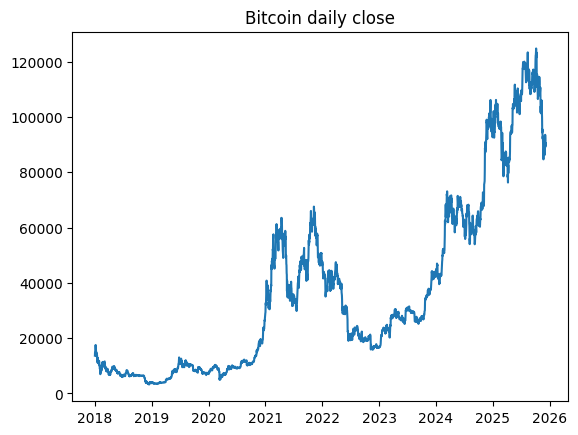

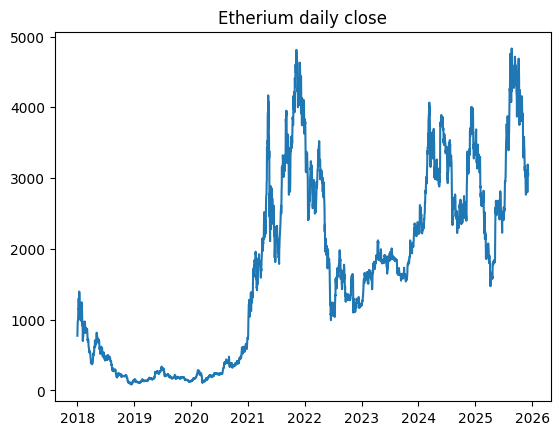

In [5]:
plt.figure()
plt.plot(df.index,df['Close']['BTC-USD'])
plt.title("Bitcoin daily close")
plt.show()
plt.figure()
plt.plot(df.index,df['Close']['ETH-USD'])
plt.title("Etherium daily close")
plt.show()

### NyTimes article:

1. **Data retrieval from the New York Times API**  
   - Uses the API key stored in the environment variable `NY_KEY`.  
   - Searches for the queries `"Bitcoin"` and `"Crypto"`.  
   - Iterates through 100 pages of results for each query.

2. **Request and error handling**  
   - Each HTTP request is executed using `requests.get`.  
   - The response status is checked with `raise_for_status()` to catch any HTTP errors.  
   - In case of an error (e.g., `429 Too Many Requests`, timeout, connection issues), the error is logged and the loop continues with the next request.

3. **Sending data to Kafka**  
   - If the response is valid, the JSON data is sent to a Kafka topic corresponding to the query (`Bitcoin` or `Crypto`).  
   - This allows real-time processing or storage of the data via a Kafka consumer.

4. **Rate limit management**  
   - After each request, the script waits 15 seconds (`time.sleep(15)`) to avoid exceeding NYT API limits, reducing the risk of `429 Too Many Requests` errors.

**Note:** The script is designed to safely scrape data while respecting the NYT API's per-minute and daily limits, sending the collected data to Kafka for further processing.


In [ ]:
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

# Imposta il periodo storico
start_date = date(2022, 10, 1)
end_date = date(2025, 12, 12)
current_date = start_date

DAILY_LIMIT = 490
calls_made = 0

key = os.getenv("NY_KEY2")
queries = ["Bitcoin", "Crypto", "Ethereum"]

while current_date < end_date:
    next_month = current_date + relativedelta(months=1)
    
    # Formatta le date per l'API NYT (YYYYMMDD)
    begin_str = current_date.strftime("%Y%m%d")
    end_str = next_month.strftime("%Y%m%d")
    
    print(f"\n--- Analisi periodo: {begin_str} - {end_str} ---")
    
    # MODIFICA 1: Iteriamo prima per Query, poi per Pagine.
    # Questo ci permette di interrompere la paginazione per una query specifica appena finiscono i dati.
    for q in queries:
        print(f"Scaricando articoli per: {q}...")
        
        for page in range(100): # Massimo 100 pagine
            if calls_made >= DAILY_LIMIT:
                print(f"RAGGIUNTO IL LIMITE GIORNALIERO ({calls_made}). Mi fermo.")
                print(f"Ultimo periodo elaborato: {begin_str} - {end_str}, Query: {q}, Pagina: {page}")
                exit()
            try:
                # MODIFICA 2: Corretto q={q} nell'URL (prima era fisso su Bitcoin)
                url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&begin_date={begin_str}&end_date={end_str}&page={page}&api-key={key}"
                
                response = requests.get(url)
                response.raise_for_status() # Solleva errore se status != 200

                data = response.json()
                articles = data.get('response', {}).get('docs', [])

                # MODIFICA 3: Se non ci sono articoli, interrompiamo il ciclo delle pagine per QUESTA query
                if not articles:
                    print(f"  -> Nessun altro articolo per '{q}' a pagina {page}. Passo alla prossima query.")
                    break 

                # Invio messaggi a Kafka
                for article in articles:
                    clean_doc = {
                        'remote_id': article.get('_id'),
                        'web_url': article.get('web_url'),
                        'pub_date': article.get('pub_date'),
                        'abstract': article.get('abstract'),
                        'lead_paragraph': article.get('lead_paragraph'),
                        'title': article.get('headline', {}).get('main'),
                        'word_count': article.get('word_count'),
                        'source_query': q
                    }
                    
                    producer.send(q, clean_doc) # Usa 'q' come nome del topic (o usa un topic unico)
            
                producer.flush()
                print(f"  -> Inviati {len(articles)} articoli per '{q}' (Pagina {page})")
                
                # Rispetta il rate limit (15 secondi sono prudenziali e sicuri)
                time.sleep(15)
                calls_made += 1

            except Exception as e:
                print(f"  -> Errore con '{q}' a pagina {page}: {e}")
                # Opzionale: se l'errore è grave (es. 429 Too Many Requests), potresti voler fare un break anche qui
                # break 
                time.sleep(15) # Attesa anche in caso di errore per sicurezza
                continue

    # Passa al mese successivo solo dopo aver finito tutte le query per il mese corrente
    current_date = next_month

1. **Kafka Consumers Setup**  
   - Two separate consumers are created:
     - `consumer_bitcoin` subscribes to the `"Bitcoin"` topic.
     - `consumer_crypto` subscribes to the `"Crypto"` topic.
   - Both consumers:
     - Connect to the Kafka broker at `localhost:9092`.
     - Deserialize messages from JSON using `json.loads`.
     - Start reading from the earliest available message (`auto_offset_reset="earliest"`) to process past messages.
     - Use a new consumer group `"debug-group"` to avoid committing offsets from previous runs.

2. **MongoDB Setup**  
   - Connects to a local MongoDB instance (`mongodb://localhost:27017`).
   - Uses the database `bitcoin_pr`.
   - Stores articles in the collection `Article`.

3. **Message Consumption and Storage**  
   - For each message received from the `"Bitcoin"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Bitcoin"`.
     - Inserts the document into the MongoDB collection.
   - For each message received from the `"Crypto"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Crypto"`.
     - Inserts the document into MongoDB.

4. **Notes**
   - Using `auto_offset_reset="earliest"` allows the consumer to read **all previous messages** in the topic, which is useful for debugging or reprocessing data.
   - Each consumer runs in a blocking loop, continuously waiting for new messages.
   - Ensure MongoDB is running locally before executing the script.



In [17]:
consumer_bitcoin = KafkaConsumer(
    "Bitcoin",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group",          # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)

consumer_crypto = KafkaConsumer(
    "Crypto",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group-crypto",         # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)

consumer_eth = KafkaConsumer(
    "Ethereum",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group-eth",         # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)



In [15]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")
# Conta articoli per query specifica
num_bitcoin = collection.count_documents({'query': 'Bitcoin'})
num_crypto = collection.count_documents({'query': 'Crypto'})
num_eth = collection.count_documents({'query': 'Ethereum'})


print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")
print(f"Number of Ethereum articles: {num_eth}")




Number of articles in the collection: 2960
Number of Bitcoin articles: 1414
Number of Crypto articles: 1342
Number of Ethereum articles: 204


C:\Users\tomma\AppData\Local\Temp\ipykernel_10148\271064846.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['mese_anno'] = df['data'].dt.to_period('M')


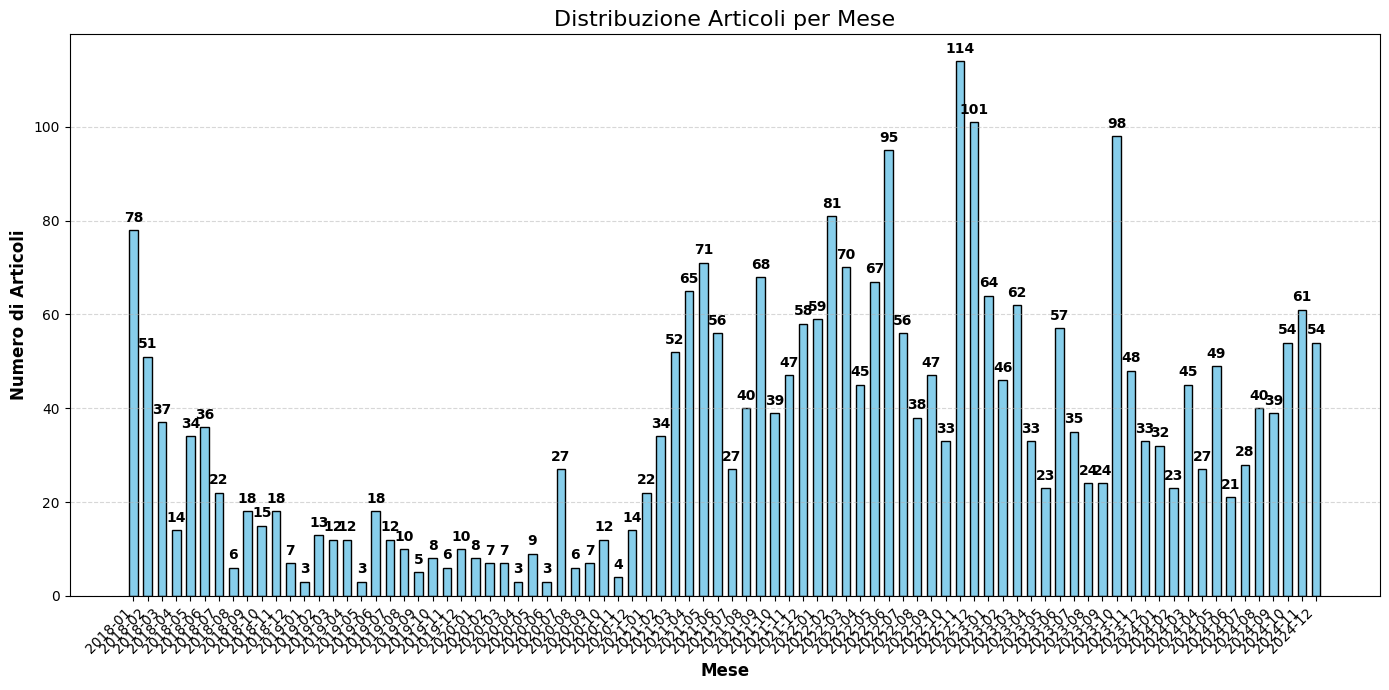

In [16]:
# 1. Connessione
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

# 2. Recupero Dati (SEMPLIFICATO)
# Non serve più l'aggregazione complessa. 
# Chiediamo a Mongo solo il campo 'pub_date' di tutti i documenti.
projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato! Assicurati di aver popolato il DB con il nuovo script.")
else:
    # 3. Preparazione DataFrame
    df = pd.DataFrame(data)
    
    # Verifica che la colonna 'pub_date' esista (per sicurezza)
    if 'pub_date' not in df.columns:
        print("ERRORE: Il campo 'pub_date' non è stato trovato nei documenti.")
        print("Esempio di documento nel DB:", collection.find_one())
    else:
        # Conversione data
        df['data'] = pd.to_datetime(df['pub_date'], errors='coerce')
        
        # Rimuove eventuali date non valide (NaT)
        df = df.dropna(subset=['data'])

        # Raggruppa per mese
        df['mese_anno'] = df['data'].dt.to_period('M')
        conteggio_mensile = df['mese_anno'].value_counts().sort_index()

        # Preparazione dati per il grafico
        mesi = conteggio_mensile.index.strftime('%Y-%m') 
        conteggi = conteggio_mensile.values

        # 4. Generazione Grafico (Il tuo codice di plotting era già ottimo!)
        plt.figure(figsize=(14, 7)) 
        
        plt.bar(mesi, conteggi, color='skyblue', edgecolor='black', width=0.6)

        plt.xlabel('Mese', fontsize=12, fontweight='bold')
        plt.ylabel('Numero di Articoli', fontsize=12, fontweight='bold')
        plt.title('Distribuzione Articoli per Mese', fontsize=16)
        
        # Formattazione asse X
        plt.xticks(
            rotation=45, 
            ha='right', 
            fontsize=10 
        )
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        # Etichette sopra le barre
        for i, v in enumerate(conteggi):
            plt.text(i, v + (max(conteggi)*0.01), str(v), ha='center', va='bottom', fontweight='bold')

        plt.subplots_adjust(bottom=0.2)
        plt.tight_layout()
        plt.show()

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_10148\3403604660.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


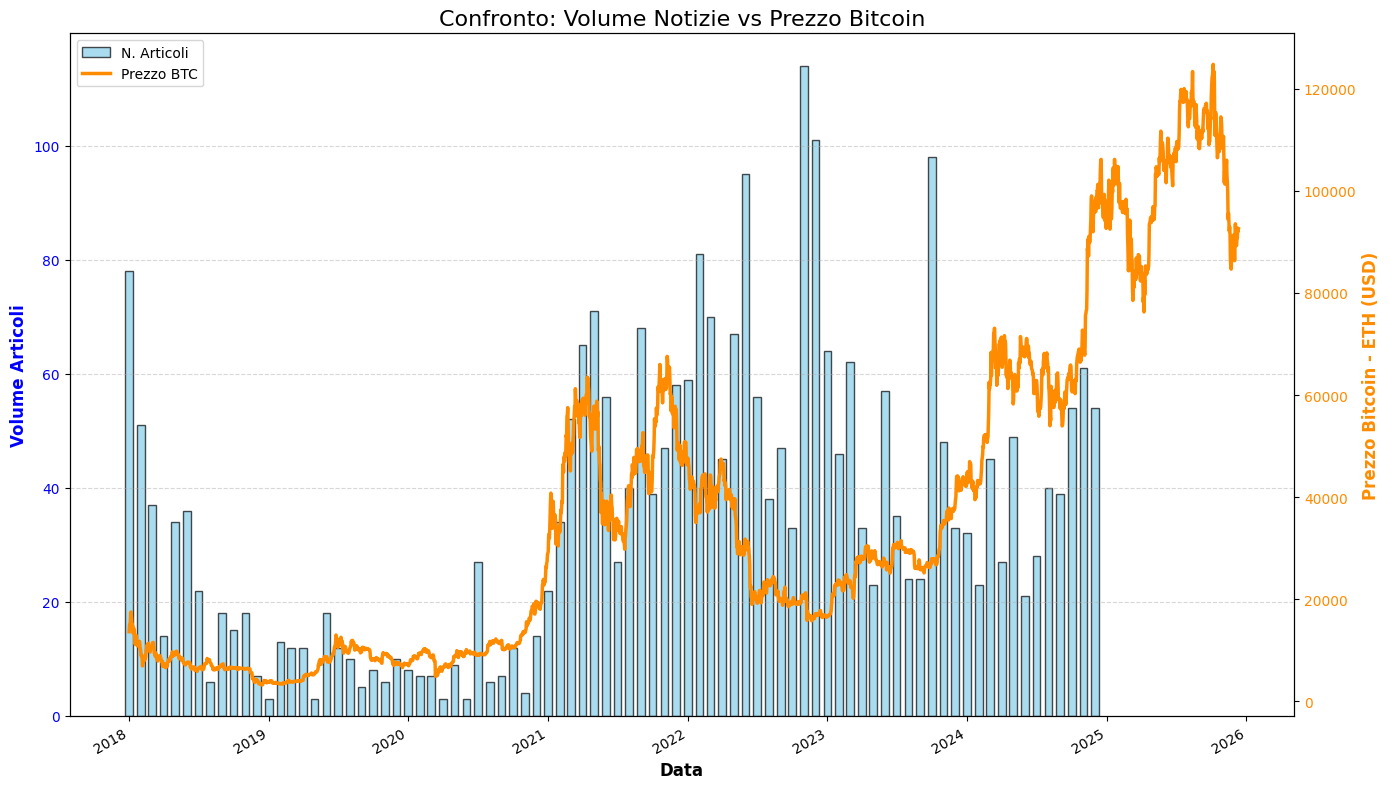

In [24]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            color_line2 = "#00FF0D" #  Eth
            color_line3 = "#D400FF"
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzo, color=color_line, linewidth=2.5, label='Prezzo BTC')


            ax2.set_ylabel('Prezzo Bitcoin - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_10148\2178150349.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


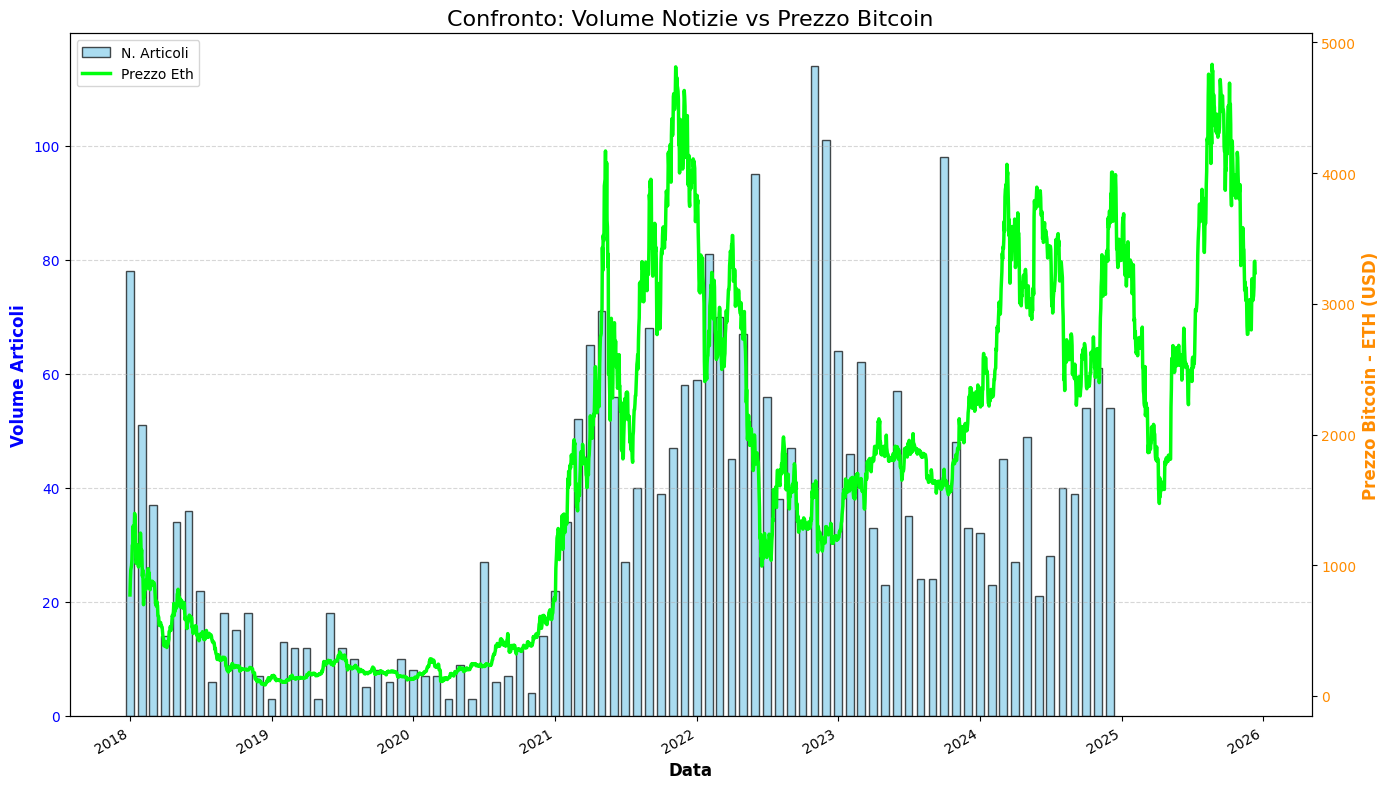

In [25]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            color_line2 = "#00FF0D" #  Eth
            color_line3 = "#D400FF"
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzoeth, color=color_line2, linewidth=2.5, label='Prezzo Eth')

            ax2.set_ylabel('Prezzo Bitcoin - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()

In [21]:
import pandas as pd
from pymongo import MongoClient
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from tqdm import tqdm
import torch

# --- 1. CONNESSIONE AL DB ---
print("🔌 Connessione a MongoDB...")
client = MongoClient("mongodb://localhost:27017")

# ⚠️ CONTROLLA IL NOME DEL DATABASE QUI SOTTO!
# Usa quello dove hai effettivamente salvato i dati (es. 'bitcoin_project_month')
db_name = 'bitcoin_project_month' 
if db_name not in client.list_database_names():
    print(f"⚠️ ATTENZIONE: Il database '{db_name}' non esiste! I DB disponibili sono: {client.list_database_names()}")
    
db = client[db_name]
collection = db['Article']

# --- 2. CARICAMENTO DATI ---
print("📥 Scarico articoli...")
# Prendiamo solo i campi che ci servono per essere più veloci
cursor = collection.find({}) 
df = pd.DataFrame(list(cursor))

if df.empty:
    print("❌ ERRORE: Nessun articolo trovato nel database. Hai eseguito il Consumer?")
else:
    print(f"✅ Trovati {len(df)} articoli.")

🔌 Connessione a MongoDB...
📥 Scarico articoli...
✅ Trovati 1023 articoli.


In [31]:
!pip install wordcloud

## Caricamento versione finale

In [3]:
from bson.json_util import loads
input_filename = 'C:\\Users\\HP\\Desktop\\data_science\\primo_anno\\DataManagement\\DataMan-Project\\completo.json' # Cambia con completo.json
db_name = 'btc_def2' # Scegli nome db
collection_name = 'Article' # Puoi cambiare nome se vuoi testare (es. 'Article_Restore')

# Connessione al DB
client = MongoClient("mongodb://localhost:27017")
db = client[db_name]
collection = db[collection_name]

print(f"--- Avvio importazione da {input_filename} a MongoDB ({collection_name}) ---")

# 1. Controllo se il file esiste
if not os.path.exists(input_filename):
    print(f"Errore: Il file '{input_filename}' non esiste.")
    exit()

try:
    # 2. Lettura del file JSON
    with open(input_filename, 'r', encoding='utf-8') as f:
        # loads (di bson) converte il testo JSON in oggetti Python (dizionari)
        # ripristinando automaticamente datetime e ObjectId
        data = loads(f.read())

    if isinstance(data, list) and len(data) > 0:
        print(f"Letti {len(data)} documenti dal file.")

        # 3. Inserimento in MongoDB (Bulk Insert)
        # ordered=False continua a inserire anche se trova un errore (es. un duplicato)
        result = collection.insert_many(data, ordered=False)
        print(f"✅ Importazione completata! Inseriti {len(result.inserted_ids)} documenti.")
        

    else:
        print("Il file JSON è vuoto o non contiene una lista di documenti.")
except Exception as e:
    print(f"❌ Errore generico durante l'importazione: {e}")

print("Fine procedura.")

--- Avvio importazione da C:\Users\HP\Desktop\data_science\primo_anno\DataManagement\DataMan-Project\completo.json a MongoDB (Article) ---
Letti 2902 documenti dal file.
✅ Importazione completata! Inseriti 2902 documenti.
Fine procedura.


In [12]:
# Connessione
client = MongoClient("mongodb://localhost:27017/")
# Assicurati che il nome sia quello usato nell'ultimo script
db = client["btc_def2"] 
collection = db["Article"]

# Funzione helper per stampare bene
def run_query(pipeline, title):
    print(f"\n=== {title} ===")
    results = list(collection.aggregate(pipeline))
    if not results:
        print("Nessun risultato trovato.")
        return
    
    df = pd.DataFrame(results)
    # Rimuoviamo colonne nidificate complesse per la stampa se serve
    if '_id' in df.columns: del df['_id']
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(df)

In [13]:
pipeline_1 = [
    # 1. Ordina per numero di articoli decrescente (dal più alto)
    { "$sort": { "article_count": -1 } },
    
    # 2. Prendi solo il primo risultato (il record assoluto)
    { "$limit": 5 },
    
    # 3. Seleziona i campi da mostrare
    {
        "$project": {
            "data": "$date_str",
            "numero_articoli": "$article_count",
            "titoli_news": "$articles.title", 
            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",
            
            # Close - Open dello stesso giorno
            "variazione_giornaliera": "$prices.BTC-USD.intraday_change",
            
            # Close (fra 7 giorni) - Close (oggi)
            "variazione_settimanale_futura": "$prices.BTC-USD.future_trend.next_week_diff"
        }
    }
]

run_query(pipeline_1, "1. Giorno con più Articoli (+ Trend Settimanale)")


=== 1. Giorno con più Articoli (+ Trend Settimanale) ===
         data  numero_articoli                                        titoli_news      btc_open     btc_close  variazione_giornaliera  variazione_settimanale_futura
0  2022-12-13               15  [In FTX Collapse, Binance Sees a Chance to Bec...  17206.441406  17781.318359              574.876953                    -875.013672
1  2022-11-30               13  [NFTs, on the Decline Elsewhere, Are Embraced ...  16445.476562  17168.566406              723.089844                    -320.439453
2  2018-06-28               13  [A Field Guide to the Hurdles Facing Blockchai...   6153.160156   5903.439941             -249.720215                     735.700195
3  2021-05-13               12  [Elon Musk Makes a Hard Swerve on Bitcoin, Tes...  49735.433594  49716.191406              -19.242188                   -8933.453125
4  2021-04-14               12  [Coinbase’s Public Listing Is a Cryptocurrency...  63523.753906  63109.695312        

In [21]:
pipeline_blind_risk = [

    # 1. Blind spot: zero articoli + BTC move
    {
        "$match": {
            "article_count": 0,
            "prices.BTC-USD.intraday_change": { "$exists": True }
        }
    },

    # 2. Volatilità + finestre temporali (±3 giorni)
    {
        "$addFields": {
            "volatilita": {
                "$abs": "$prices.BTC-USD.intraday_change"
            },
            "start_3d_before": {
                "$subtract": ["$date", 3 * 24 * 60 * 60 * 1000]
            },
            "end_3d_after": {
                "$add": ["$date", 3 * 24 * 60 * 60 * 1000]
            }
        }
    },

    # 3. Lookup: 3 giorni PRIMA
    {
        "$lookup": {
            "from": "Article",
            "let": {
                "start": "$start_3d_before",
                "blind": "$date"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gte": ["$date", "$$start"] },
                                { "$lt": ["$date", "$$blind"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "tot_articoli": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_before"
        }
    },

    # 4. Lookup: 3 giorni DOPO
    {
        "$lookup": {
            "from": "Article",
            "let": {
                "blind": "$date",
                "end": "$end_3d_after"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gt": ["$date", "$$blind"] },
                                { "$lte": ["$date", "$$end"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "tot_articoli": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_after"
        }
    },

    # 5. Flatten risultati lookup
    {
        "$addFields": {
            "articoli_3g_pre": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_before.tot_articoli", 0] },
                    0
                ]
            },
            "articoli_3g_post": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_after.tot_articoli", 0] },
                    0
                ]
            }
        }
    },

    # 6. Ordina per rischio (volatilità)
    { "$sort": { "volatilita": -1 } },
    { "$limit": 5 },

    # 7. Output finale
    {
        "$project": {
            "_id": 0,
            "data": "$date_str",

            "articoli_giorno": "$article_count",
            "articoli_3g_pre": 1,
            "articoli_3g_post": 1,

            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",

            "variazione_giornaliera": "$prices.BTC-USD.intraday_change",
            "volatilita_assoluta": "$volatilita",

            "variazione_settimanale_futura":
                "$prices.BTC-USD.future_trend.next_week_diff"
        }
    }
]

run_query(
    pipeline_blind_risk,
    "Blind Spot ±3 giorni (News vacuum + Volatilità)"
)



=== Blind Spot ±3 giorni (News vacuum + Volatilità) ===
   articoli_3g_pre  articoli_3g_post        data  articoli_giorno       btc_open      btc_close  variazione_giornaliera  volatilita_assoluta  variazione_settimanale_futura
0                5                 3  2021-11-26                0   58960.285156   53569.765625            -5390.519531          5390.519531                      28.480469
1                2                 8  2025-04-06                0   83504.507812   78214.484375            -5290.023438          5290.023438                    5470.492188
2                7                 8  2025-11-04                0  106541.421875  101590.523438            -4950.898438          4950.898438                    1406.945312
3               11                 2  2024-05-15                0   61553.988281   66267.492188             4713.503906          4713.503906                    2854.843750
4                1                 5  2025-06-23                0  100987.476562  1

In [23]:
pipeline_sync = [

    # 1. Giorni con news
    {
        "$match": {
            "article_count": { "$gt": 0 },
            "prices.BTC-USD.intraday_change": { "$exists": True }
        }
    },

    # 2. Volatilità assoluta
    {
        "$addFields": {
            "volatilita": {
                "$abs": "$prices.BTC-USD.intraday_change"
            }
        }
    },

    # 3. Ordina per numero articoli
    {
        "$sort": { "article_count": -1 }
    },

    # 4. Limite
    {
        "$limit": 100
    },

    # 5. Output finale coerente
    {
        "$project": {
            "_id": 0,
            "data": "$date_str",

            "numero_articoli": "$article_count",
            "titoli_news": "$articles.title",

            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",

            "variazione_giornaliera":
                "$prices.BTC-USD.intraday_change",

            "volatilita_assoluta": "$volatilita",

            # 🔙 variazione settimanale PRECEDENTE
            "variazione_settimanale_precedente": {
                "$cond": [
                    { "$ne": ["$prices.BTC-USD.context.close_prev_week", None] },
                    {
                        "$subtract": [
                            "$prices.BTC-USD.close",
                            "$prices.BTC-USD.context.close_prev_week"
                        ]
                    },
                    None
                ]
            },

            # 🔜 variazione settimanale FUTURA
            "variazione_settimanale_futura":
                "$prices.BTC-USD.future_trend.next_week_diff"
        }
    }
]

run_query(
    pipeline_sync,
    "Top News Days (News ↔ Volatilità | Δ sett. pre/post)"
)



=== Top News Days (News ↔ Volatilità | Δ sett. pre/post) ===
          data  numero_articoli                                        titoli_news      btc_open     btc_close  variazione_giornaliera  volatilita_assoluta  variazione_settimanale_precedente  variazione_settimanale_futura
0   2022-12-13               15  [In FTX Collapse, Binance Sees a Chance to Bec...  17206.441406  17781.318359              574.876953           574.876953                         691.814453                    -875.013672
1   2018-06-28               13  [A Field Guide to the Hurdles Facing Blockchai...   6153.160156   5903.439941             -249.720215           249.720215                        -826.300293                     735.700195
2   2022-11-30               13  [NFTs, on the Decline Elsewhere, Are Embraced ...  16445.476562  17168.566406              723.089844           723.089844                         557.859375                    -320.439453
3   2021-05-13               12  [Elon Musk Makes 

## Wordcloud

🔌 Connesso a MongoDB: btc_def2.Article
🤖 Caricamento FinBERT in corso...


Device set to use cpu


✅ Modello caricato!

--- 🔍 ANALISI PERIODO: 1. Crollo COVID 🦠 (2020-03-01 - 2020-03-31) ---
📥 Trovati 31 giorni nel DB. Elaborazione articoli...


Processing: 100%|██████████| 31/31 [00:00<00:00, 44.09it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\3162512743.py:172: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129440 (\N{MICROBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


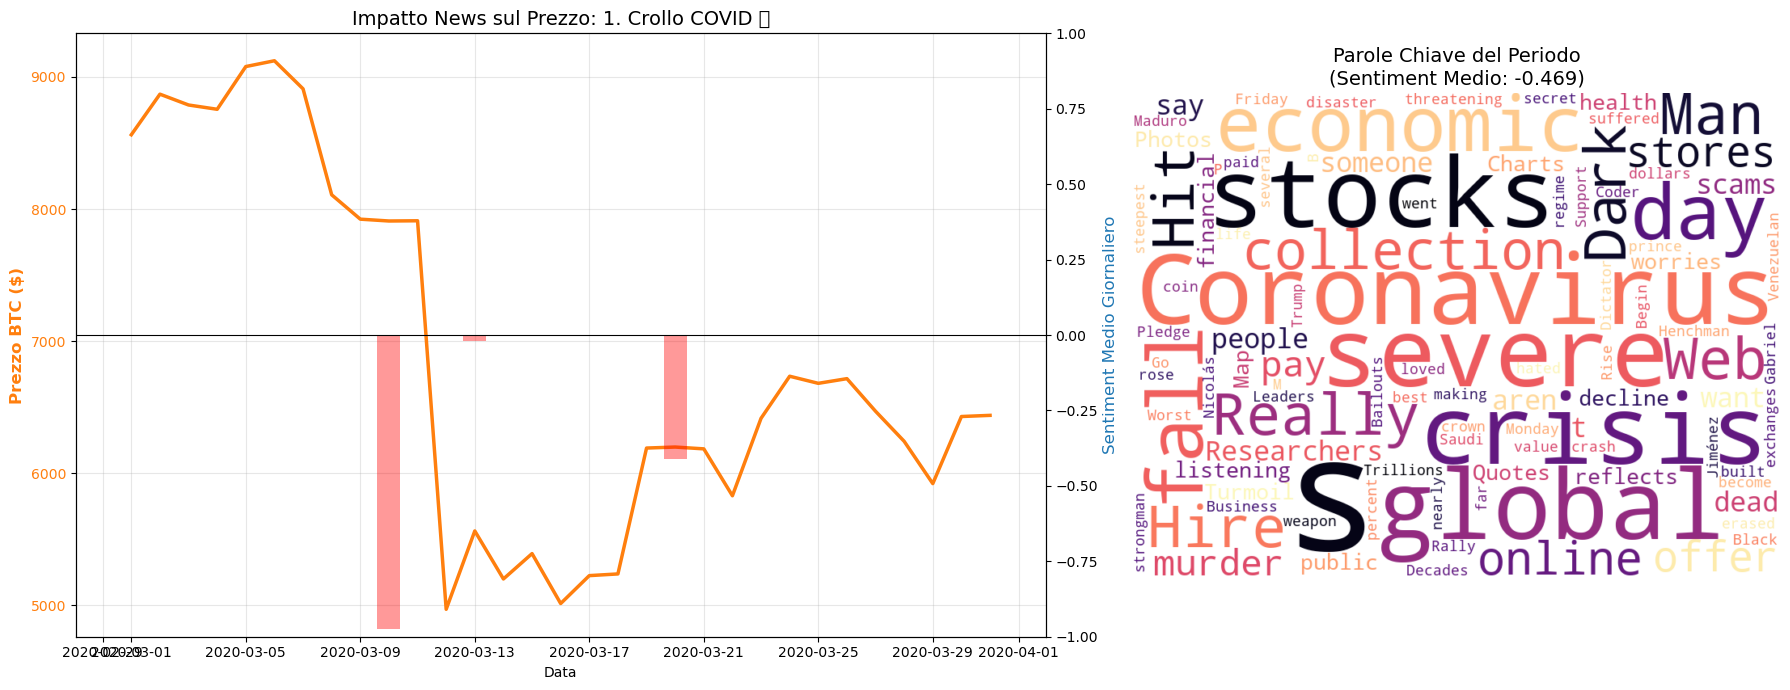


--- 🔍 ANALISI PERIODO: 2. Ban Cina & Musk 🇨🇳 (2021-05-01 - 2021-05-31) ---
📥 Trovati 31 giorni nel DB. Elaborazione articoli...


Processing: 100%|██████████| 31/31 [00:03<00:00,  7.97it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\3162512743.py:172: UserWarning: Glyph 127464 (\N{REGIONAL INDICATOR SYMBOL LETTER C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\3162512743.py:172: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127464 (\N{REGIONAL INDICATOR SYMBOL LETTER C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127475 (\N{REGIONAL INDICATOR SYMBOL LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


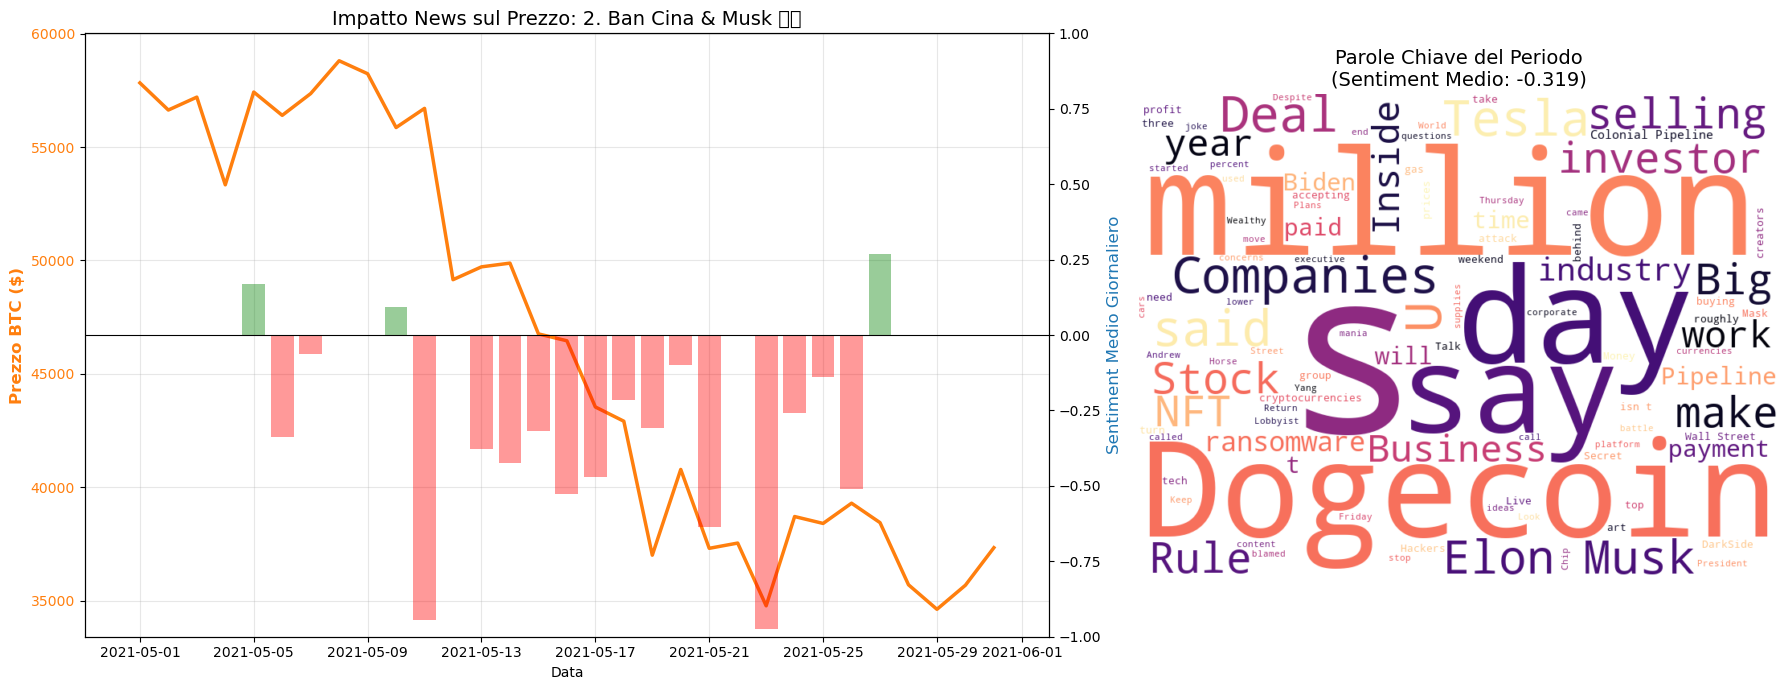


--- 🔍 ANALISI PERIODO: 3. Crollo FTX 📉 (2022-11-01 - 2022-11-30) ---
📥 Trovati 30 giorni nel DB. Elaborazione articoli...


Processing: 100%|██████████| 30/30 [00:05<00:00,  5.29it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\3162512743.py:172: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


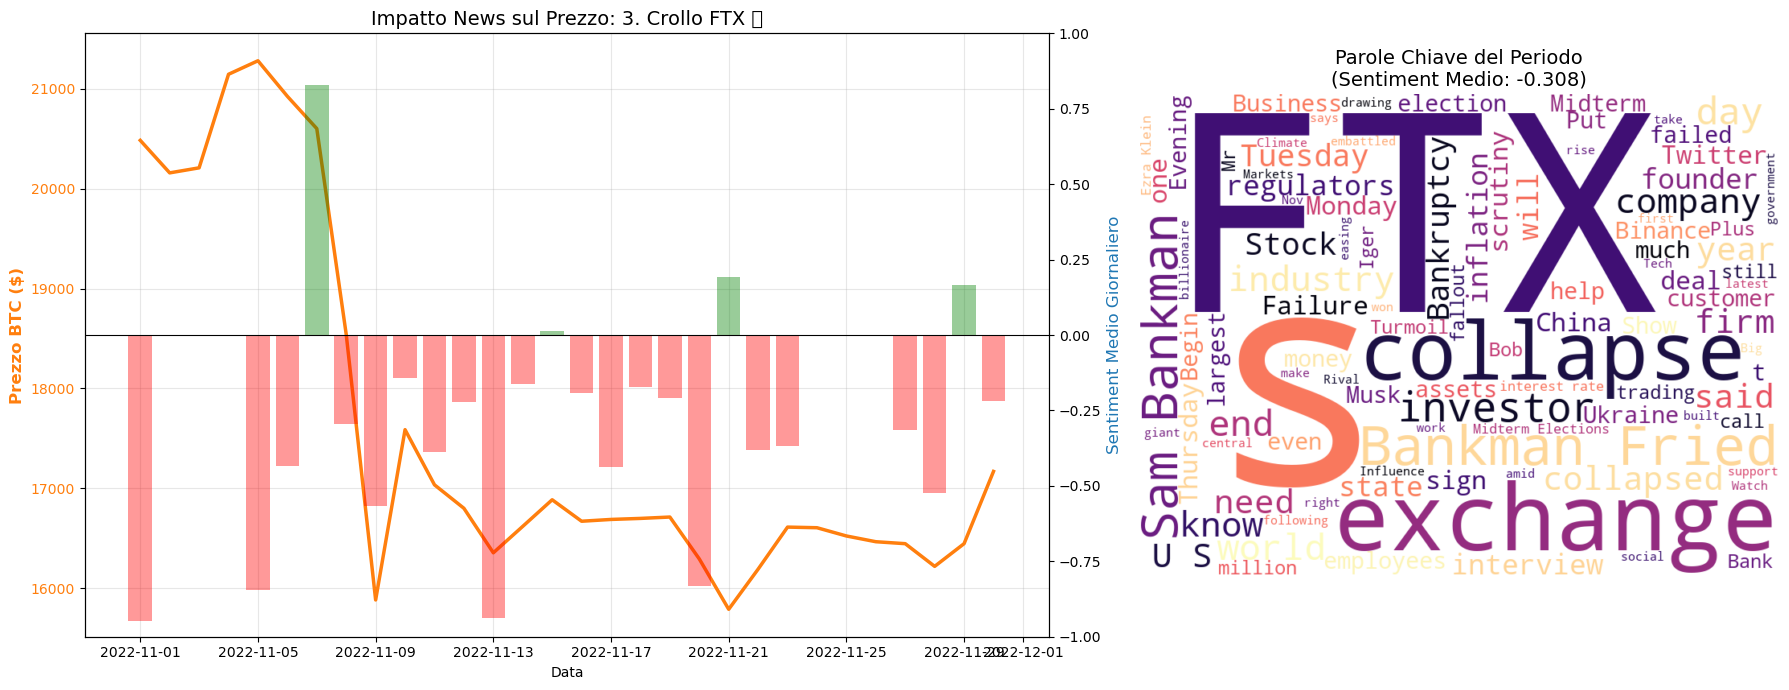


--- 🔍 ANALISI PERIODO: 4. ETF Approval 🏛️ (2024-01-01 - 2024-01-31) ---
📥 Trovati 31 giorni nel DB. Elaborazione articoli...


Processing: 100%|██████████| 31/31 [00:01<00:00, 17.09it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\3162512743.py:172: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127963 (\N{CLASSICAL BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


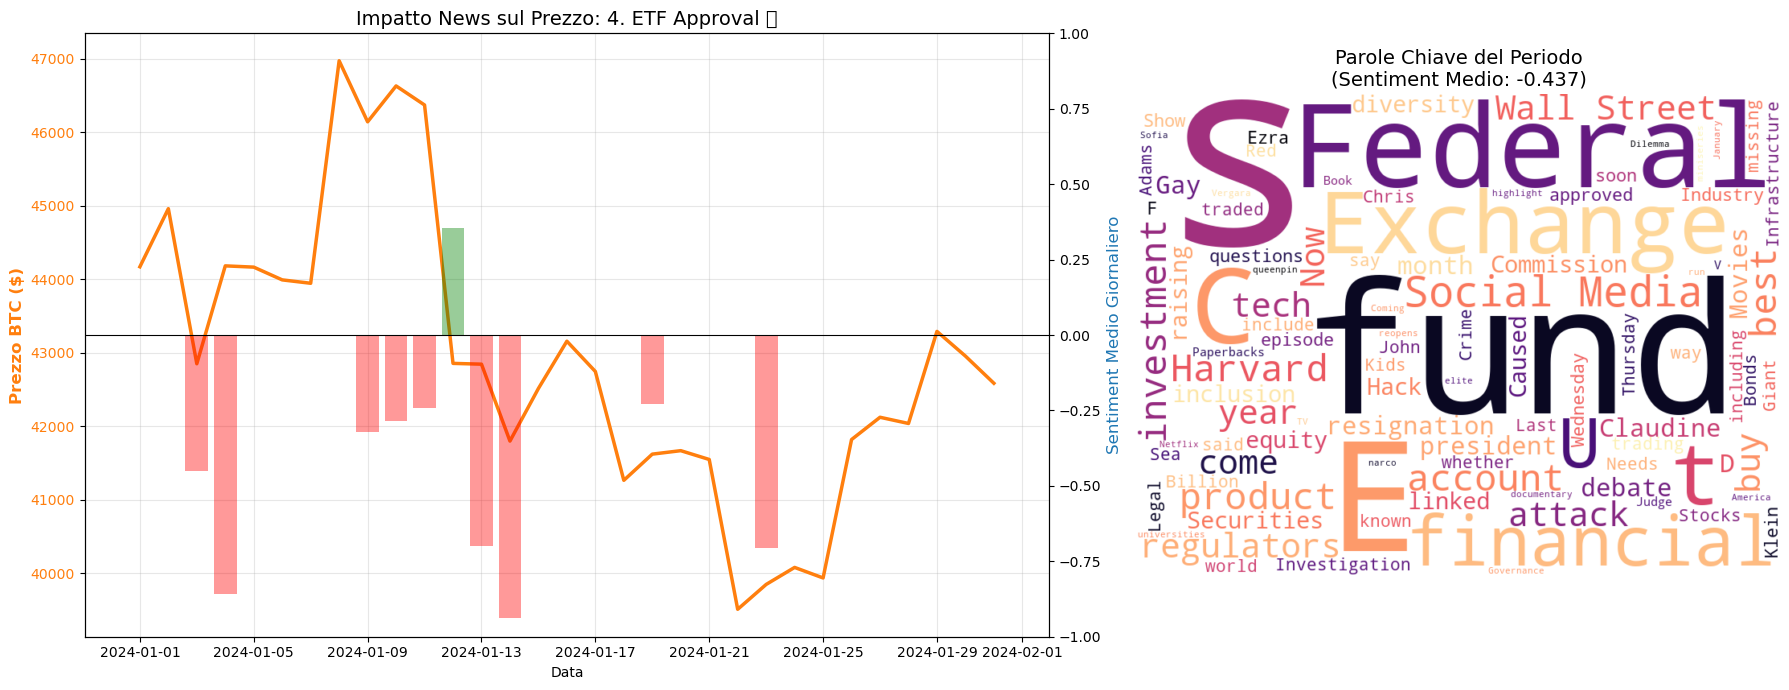

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from pymongo import MongoClient
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from tqdm import tqdm
import torch

# --- 1. CONNESSIONE AL DB ESISTENTE ---
client = MongoClient("mongodb://localhost:27017")
db_name = 'btc_def2'    # Il nome che hai usato nell'importazione
collection_name = 'Article' 
db = client[db_name]
collection = db[collection_name]

print(f"🔌 Connesso a MongoDB: {db_name}.{collection_name}")

# --- 2. CARICAMENTO MODELLO FINBERT ---
print("🤖 Caricamento FinBERT in corso...")
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Usa GPU se disponibile, altrimenti CPU
device = 0 if torch.cuda.is_available() else -1
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
print("✅ Modello caricato!")

# --- 3. FUNZIONE DI ANALISI (QUERY MONGO + NLP) ---
def analyze_mongo_period(start_date, end_date, event_title):
    print(f"\n--- 🔍 ANALISI PERIODO: {event_title} ({start_date} - {end_date}) ---")
    
    # A. QUERY MONGODB
    # Cerchiamo i documenti dove 'date_str' è compreso tra le due date
    query = {
        "date_str": {
            "$gte": start_date,
            "$lte": end_date
        }
    }
    
    # Ordiniamo per data crescente
    cursor = collection.find(query).sort("date_str", 1)
    days_found = list(cursor)
    
    if not days_found:
        print("❌ Nessun dato trovato in questo intervallo temporale.")
        return

    print(f"📥 Trovati {len(days_found)} giorni nel DB. Elaborazione articoli...")

    # Variabili per accumulare i dati
    dates_plot = []
    prices_plot = []
    sentiments_plot = []
    
    all_text_for_cloud = "" # Stringona unica per la WordCloud
    total_articles_processed = 0

    # B. CICLO SUI GIORNI
    for doc in tqdm(days_found, desc="Processing"):
        
        # 1. Estrazione Data e Prezzo
        date_val = doc.get('date_str')
        try:
            # Navighiamo nel JSON per trovare il prezzo
            close_price = doc['prices']['BTC-USD']['close']
        except (KeyError, TypeError):
            close_price = None # Se manca il prezzo, mettiamo None
            
        # 2. Estrazione e Analisi Articoli
        articles = doc.get('articles', [])
        daily_scores = []
        
        for art in articles:
            # Uniamo Titolo e Abstract
            title = art.get('title', '')
            abstract = art.get('abstract', '')
            # Pulizia base: se sono None diventano stringa vuota
            if title is None: title = ""
            if abstract is None: abstract = ""
            
            full_text = f"{title}. {abstract}".strip()
            
            # Processiamo solo se c'è testo
            if len(full_text) > 10:
                # Accumula per WordCloud
                all_text_for_cloud += " " + full_text
                
                # Calcola Sentiment FinBERT
                try:
                    # Tronchiamo a 512 caratteri per sicurezza
                    res = nlp(full_text[:512])[0]
                    
                    score = res['score']
                    label = res['label']
                    
                    # Mapping: Positive -> +score, Negative -> -score, Neutral -> 0
                    if label == 'negative':
                        val = -score
                    elif label == 'neutral':
                        val = 0
                    else:
                        val = score
                        
                    daily_scores.append(val)
                    total_articles_processed += 1
                except Exception as e:
                    pass # Ignora errori su singoli testi strani

        # 3. Aggregazione Giornaliera
        dates_plot.append(pd.to_datetime(date_val))
        prices_plot.append(close_price)
        
        if daily_scores:
            sentiments_plot.append(np.mean(daily_scores))
        else:
            sentiments_plot.append(0) # 0 se non ci sono news quel giorno

    # --- 4. VISUALIZZAZIONE ---
    if total_articles_processed == 0:
        print("⚠️ Nessun articolo valido trovato per l'analisi del testo.")
        return

    avg_period_sentiment = np.mean([s for s in sentiments_plot if s != 0]) if any(s != 0 for s in sentiments_plot) else 0
    
    # Creazione Dashboard Grafica (2 Colonne)
    fig = plt.figure(figsize=(18, 7))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])

    # GRAFICO SINISTRA: Prezzo + Sentiment
    ax1 = fig.add_subplot(gs[0])
    color_price = 'tab:orange'
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Prezzo BTC ($)', color=color_price, fontsize=12, fontweight='bold')
    ax1.plot(dates_plot, prices_plot, color=color_price, linewidth=2.5, label='Prezzo BTC')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f"Impatto News sul Prezzo: {event_title}", fontsize=14)

    # Asse gemello per le barre del sentiment
    ax2 = ax1.twinx()
    color_sent = 'tab:blue'
    ax2.set_ylabel('Sentiment Medio Giornaliero', color=color_sent, fontsize=12)
    
    # Colora le barre: Verde se > 0, Rosso se < 0
    bar_colors = ['green' if s > 0 else 'red' for s in sentiments_plot]
    ax2.bar(dates_plot, sentiments_plot, alpha=0.4, color=bar_colors, width=0.8, label='Daily Sentiment')
    ax2.set_ylim(-1, 1) # Forza la scala da -1 a 1
    ax2.axhline(0, color='black', linewidth=0.8)

    # GRAFICO DESTRA: WordCloud
    ax3 = fig.add_subplot(gs[1])
    
    # Stopwords per pulire la nuvola
    my_stopwords = set(STOPWORDS)
    my_stopwords.update(["Bitcoin", "Crypto", "Cryptocurrency", "Currency", "Digital", "Price", "Market", "New", "York", "Times", "Briefing", "Week"])
    
    # Scegli colormap in base al sentiment generale del periodo
    cmap = 'Reds' if avg_period_sentiment < 0 else 'Greens'
    
    wc = WordCloud(width=800, height=600, 
                   background_color='white', 
                   stopwords=my_stopwords,
                   colormap='magma', # Usa 'magma' o 'viridis' per contrasto alto
                   max_words=100).generate(all_text_for_cloud)
    
    ax3.imshow(wc, interpolation='bilinear')
    ax3.axis('off')
    ax3.set_title(f"Parole Chiave del Periodo\n(Sentiment Medio: {avg_period_sentiment:.3f})", fontsize=14)

    plt.tight_layout()
    plt.show()

# --- 4. DEFINIZIONE ED ESECUZIONE PERIODI ---

# Lista dei periodi critici (Event-Driven Analysis)
# Puoi modificare/aggiungere date qui
periods_to_analyze = [
    # Titolo Evento            Start         End
    ("1. Crollo COVID 🦠",    "2020-03-01", "2020-03-31"),
    ("2. Ban Cina & Musk 🇨🇳", "2021-05-01", "2021-05-31"),
    ("3. Crollo FTX 📉",      "2022-11-01", "2022-11-30"),
    ("4. ETF Approval 🏛️",    "2024-01-01", "2024-01-31")
]

# Eseguiamo il ciclo
for title, start, end in periods_to_analyze:
    analyze_mongo_period(start, end, title)

🔌 Connesso a MongoDB: btc_def2.Article
🤖 Caricamento FinBERT in corso...


Device set to use cpu


✅ Modello caricato!

--- 🔍 ANALISI PERIODO: 1. Adozione PayPal/Corporate 💳 (2020-10-01 - 2020-12-31) ---
📥 Trovati 92 giorni nel DB. Elaborazione articoli...


Processing: 100%|██████████| 92/92 [00:01<00:00, 46.78it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\2865098960.py:164: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


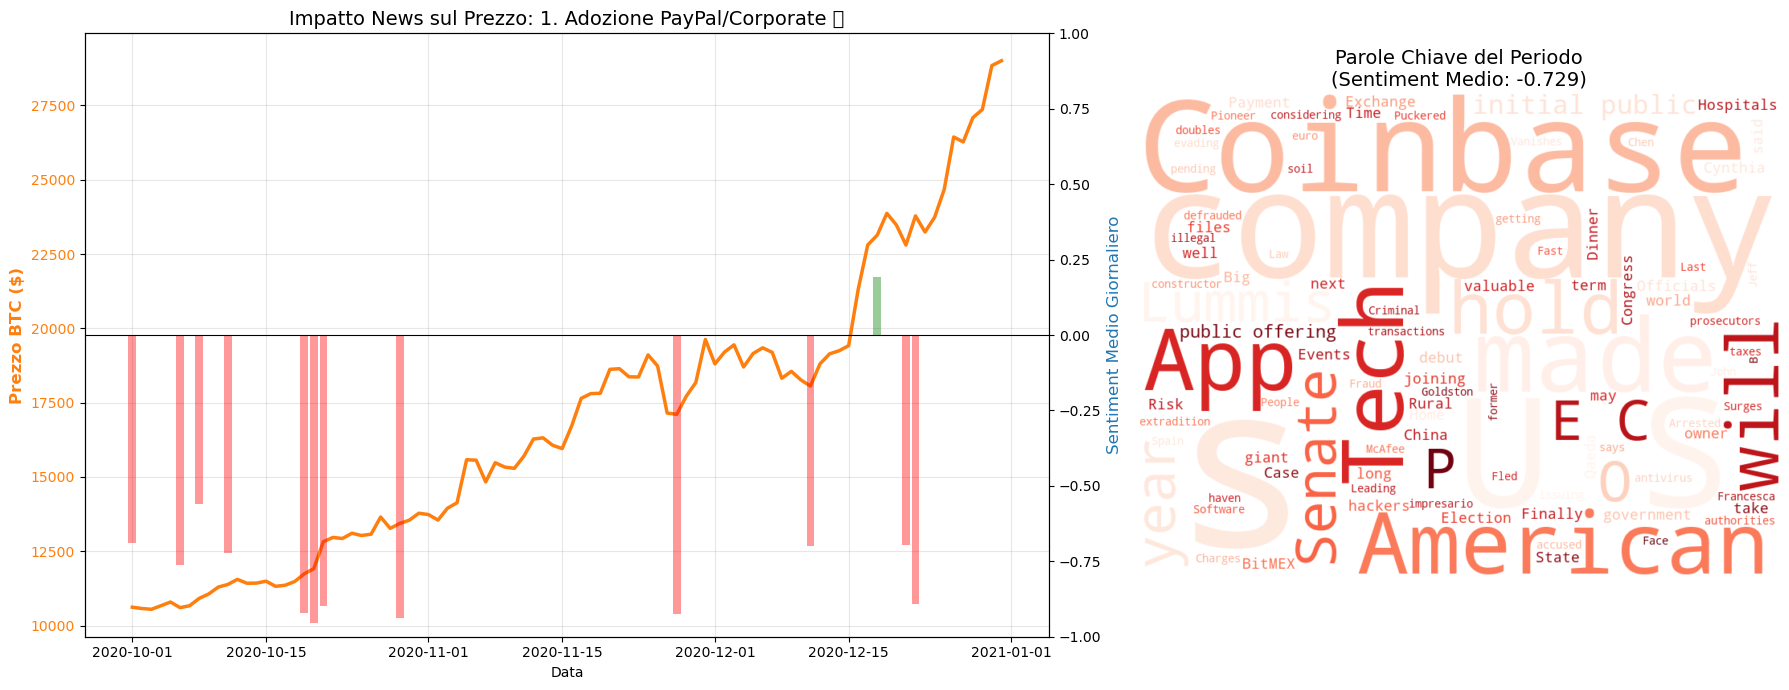


--- 🔍 ANALISI PERIODO: 2. Picco 'Inflation Hedge' 📈 (2021-10-01 - 2021-11-15) ---
📥 Trovati 46 giorni nel DB. Elaborazione articoli...


Processing: 100%|██████████| 46/46 [00:02<00:00, 16.11it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\2865098960.py:164: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


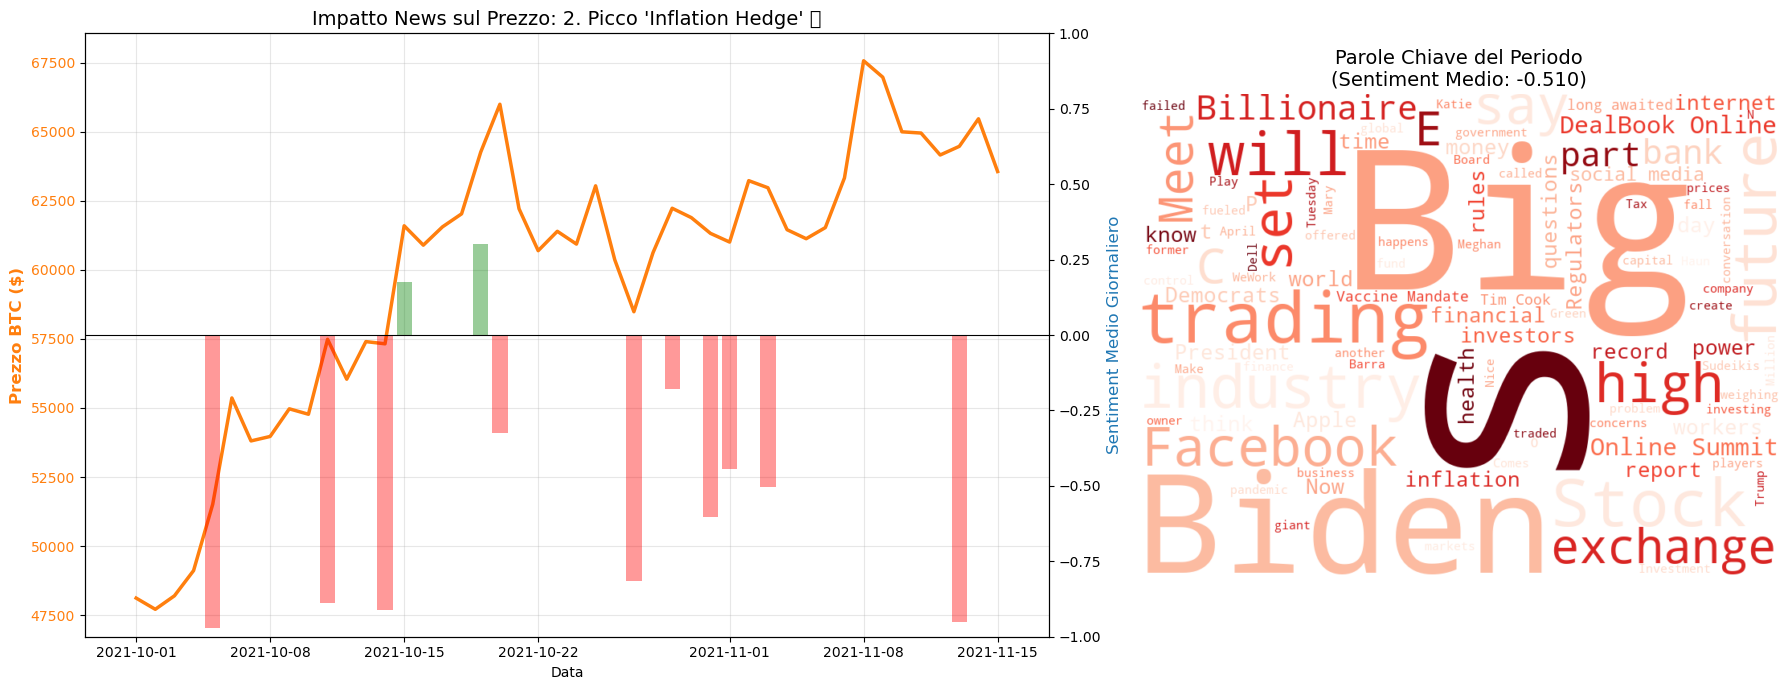


--- 🔍 ANALISI PERIODO: 3. BlackRock & Pre-ETF 👔 (2023-10-15 - 2023-12-31) ---
📥 Trovati 78 giorni nel DB. Elaborazione articoli...


Processing: 100%|██████████| 78/78 [00:06<00:00, 12.11it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\2865098960.py:164: UserWarning: Glyph 128084 (\N{NECKTIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128084 (\N{NECKTIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


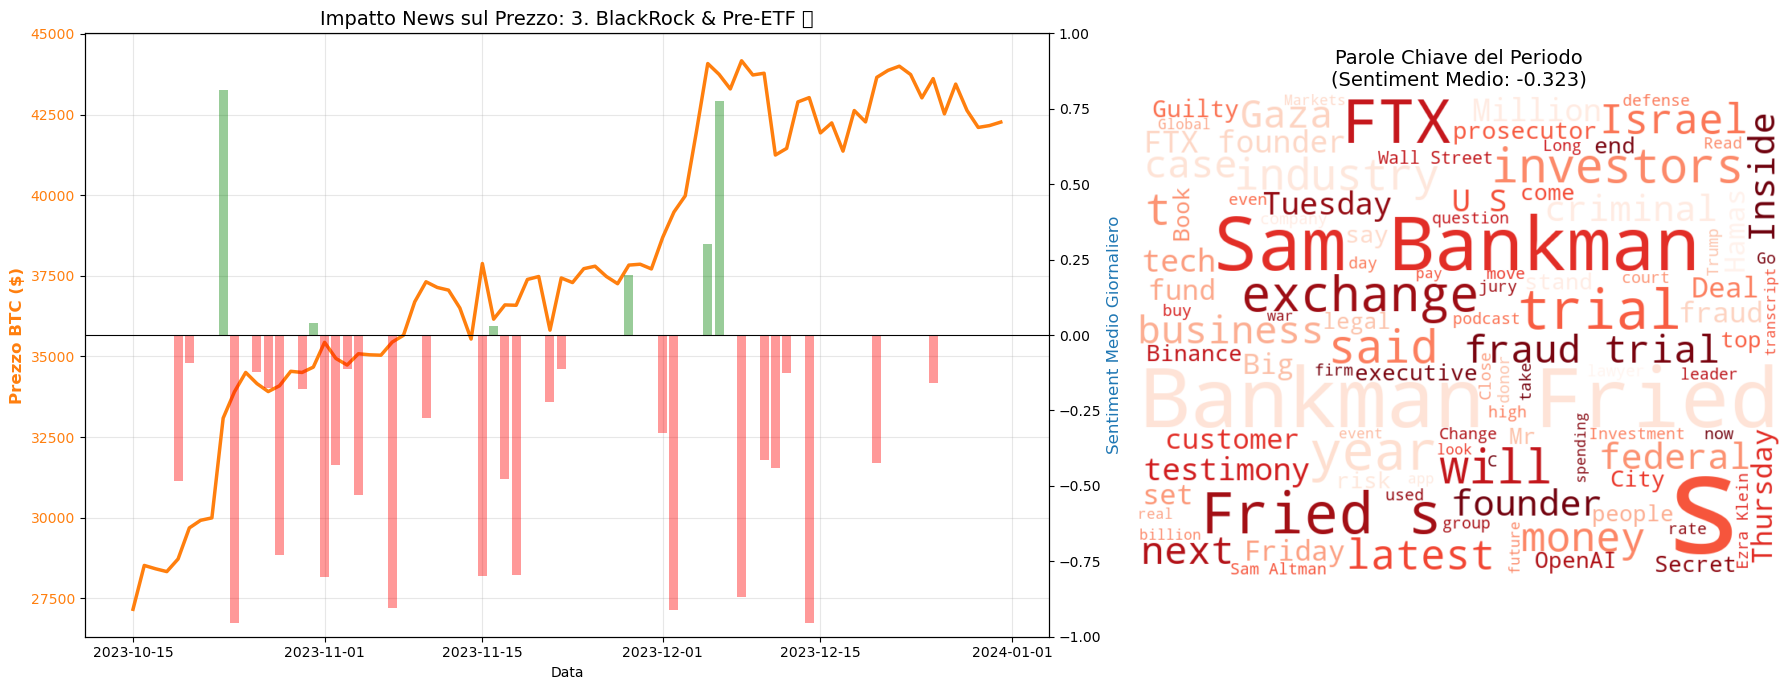


--- 🔍 ANALISI PERIODO: 4. Trump & Post-Elezioni 🇺🇸 (2024-11-05 - 2024-12-31) ---
📥 Trovati 57 giorni nel DB. Elaborazione articoli...


Processing: 100%|██████████| 57/57 [00:06<00:00,  9.42it/s]
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\2865098960.py:164: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\2865098960.py:164: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


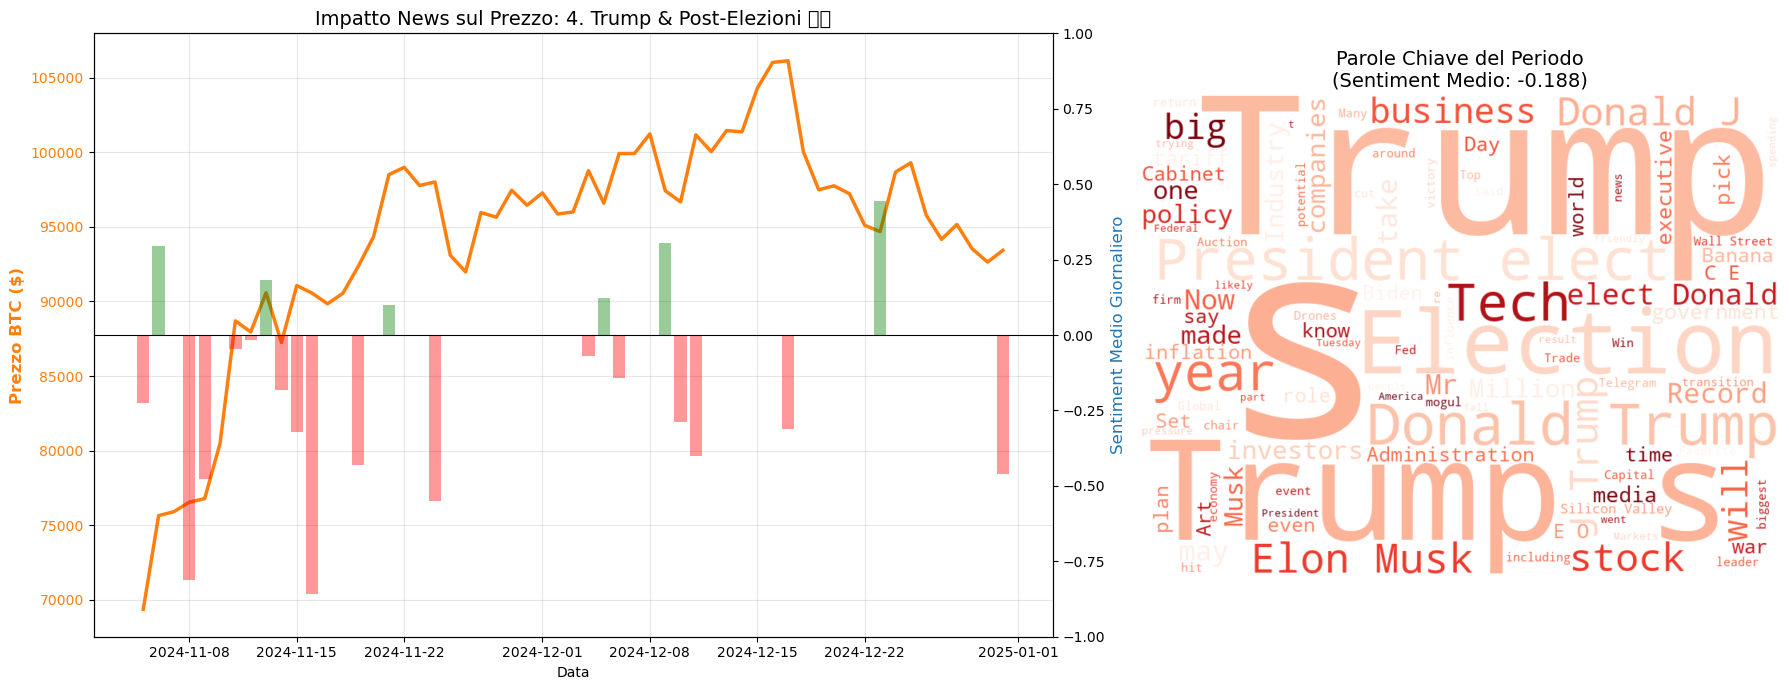

In [25]:
# --- 1. CONNESSIONE AL DB ESISTENTE ---
client = MongoClient("mongodb://localhost:27017")
db_name = 'btc_def2'    # Il nome del tuo DB
collection_name = 'Article' 
db = client[db_name]
collection = db[collection_name]

print(f"🔌 Connesso a MongoDB: {db_name}.{collection_name}")

# --- 2. CARICAMENTO MODELLO FINBERT ---
print("🤖 Caricamento FinBERT in corso...")
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Usa GPU se disponibile, altrimenti CPU
device = 0 if torch.cuda.is_available() else -1
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)
print("✅ Modello caricato!")

# --- 3. FUNZIONE DI ANALISI (QUERY MONGO + NLP) ---
def analyze_mongo_period(start_date, end_date, event_title):
    print(f"\n--- 🔍 ANALISI PERIODO: {event_title} ({start_date} - {end_date}) ---")
    
    # A. QUERY MONGODB
    # Cerchiamo i documenti dove 'date_str' è compreso tra le due date
    query = {
        "date_str": {
            "$gte": start_date,
            "$lte": end_date
        }
    }
    
    # Ordiniamo per data crescente
    cursor = collection.find(query).sort("date_str", 1)
    days_found = list(cursor)
    
    if not days_found:
        print("❌ Nessun dato trovato in questo intervallo temporale.")
        return

    print(f"📥 Trovati {len(days_found)} giorni nel DB. Elaborazione articoli...")

    # Variabili per accumulare i dati
    dates_plot = []
    prices_plot = []
    sentiments_plot = []
    
    all_text_for_cloud = "" # Stringona unica per la WordCloud
    total_articles_processed = 0

    # B. CICLO SUI GIORNI
    for doc in tqdm(days_found, desc="Processing"):
        
        # 1. Estrazione Data e Prezzo
        date_val = doc.get('date_str')
        try:
            # Navighiamo nel JSON per trovare il prezzo
            close_price = doc['prices']['BTC-USD']['close']
        except (KeyError, TypeError):
            close_price = None # Se manca il prezzo, mettiamo None
            
        # 2. Estrazione e Analisi Articoli
        articles = doc.get('articles', [])
        daily_scores = []
        
        for art in articles:
            # Uniamo Titolo e Abstract
            title = art.get('title', '')
            abstract = art.get('abstract', '')
            # Pulizia base: se sono None diventano stringa vuota
            if title is None: title = ""
            if abstract is None: abstract = ""
            
            full_text = f"{title}. {abstract}".strip()
            
            # Processiamo solo se c'è testo
            if len(full_text) > 10:
                # Accumula per WordCloud
                all_text_for_cloud += " " + full_text
                
                # Calcola Sentiment FinBERT
                try:
                    # Tronchiamo a 512 caratteri per sicurezza
                    res = nlp(full_text[:512])[0]
                    
                    score = res['score']
                    label = res['label']
                    
                    # Mapping: Positive -> +score, Negative -> -score, Neutral -> 0
                    if label == 'negative':
                        val = -score
                    elif label == 'neutral':
                        val = 0
                    else:
                        val = score
                        
                    daily_scores.append(val)
                    total_articles_processed += 1
                except Exception as e:
                    pass # Ignora errori su singoli testi strani

        # 3. Aggregazione Giornaliera
        dates_plot.append(pd.to_datetime(date_val))
        prices_plot.append(close_price)
        
        if daily_scores:
            sentiments_plot.append(np.mean(daily_scores))
        else:
            sentiments_plot.append(0) # 0 se non ci sono news quel giorno

    # --- 4. VISUALIZZAZIONE ---
    if total_articles_processed == 0:
        print("⚠️ Nessun articolo valido trovato per l'analisi del testo.")
        return

    avg_period_sentiment = np.mean([s for s in sentiments_plot if s != 0]) if any(s != 0 for s in sentiments_plot) else 0
    
    # Creazione Dashboard Grafica (2 Colonne)
    fig = plt.figure(figsize=(18, 7))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])

    # GRAFICO SINISTRA: Prezzo + Sentiment
    ax1 = fig.add_subplot(gs[0])
    color_price = 'tab:orange'
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Prezzo BTC ($)', color=color_price, fontsize=12, fontweight='bold')
    ax1.plot(dates_plot, prices_plot, color=color_price, linewidth=2.5, label='Prezzo BTC')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f"Impatto News sul Prezzo: {event_title}", fontsize=14)

    # Asse gemello per le barre del sentiment
    ax2 = ax1.twinx()
    color_sent = 'tab:blue'
    ax2.set_ylabel('Sentiment Medio Giornaliero', color=color_sent, fontsize=12)
    
    # Colora le barre: Verde se > 0, Rosso se < 0
    bar_colors = ['green' if s > 0 else 'red' for s in sentiments_plot]
    ax2.bar(dates_plot, sentiments_plot, alpha=0.4, color=bar_colors, width=0.8, label='Daily Sentiment')
    ax2.set_ylim(-1, 1) # Forza la scala da -1 a 1
    ax2.axhline(0, color='black', linewidth=0.8)

    # GRAFICO DESTRA: WordCloud
    ax3 = fig.add_subplot(gs[1])
    
    # Stopwords per pulire la nuvola
    my_stopwords = set(STOPWORDS)
    my_stopwords.update(["Bitcoin", "Crypto", "Cryptocurrency", "Currency", "Digital", "Price", "Market", "New", "York", "Times", "Briefing", "Week"])
    
    # Scegli colormap in base al sentiment generale del periodo
    # Se il periodo è positivo (crescita), usiamo toni verdi/blu
    cmap = 'Reds' if avg_period_sentiment < 0 else 'viridis'
    
    wc = WordCloud(width=800, height=600, 
                   background_color='white', 
                   stopwords=my_stopwords,
                   colormap=cmap, 
                   max_words=100).generate(all_text_for_cloud)
    
    ax3.imshow(wc, interpolation='bilinear')
    ax3.axis('off')
    ax3.set_title(f"Parole Chiave del Periodo\n(Sentiment Medio: {avg_period_sentiment:.3f})", fontsize=14)

    plt.tight_layout()
    plt.show()

# --- 4. DEFINIZIONE ED ESECUZIONE PERIODI DI CRESCITA ---

periods_to_analyze = [
    # Titolo Evento                       Start         End
    ("1. Adozione PayPal/Corporate 💳",  "2020-10-01", "2020-12-31"),
    ("2. Picco 'Inflation Hedge' 📈",    "2021-10-01", "2021-11-15"),
    ("3. BlackRock & Pre-ETF 👔",        "2023-10-15", "2023-12-31"),
    ("4. Trump & Post-Elezioni 🇺🇸",      "2024-11-05", "2024-12-31") 
]

# Eseguiamo il ciclo
for title, start, end in periods_to_analyze:
    analyze_mongo_period(start, end, title)

ANNO       | ARTICOLI TOTALI | GIORNI NEL DB  
---------------------------------------------
2018       | 336             | 365            
2019       | 112             | 365            
2020       | 107             | 366            
2021       | 579             | 365            
2022       | 806             | 365            
2023       | 547             | 365            
2024       | 473             | 366            
2025       | 698             | 345            


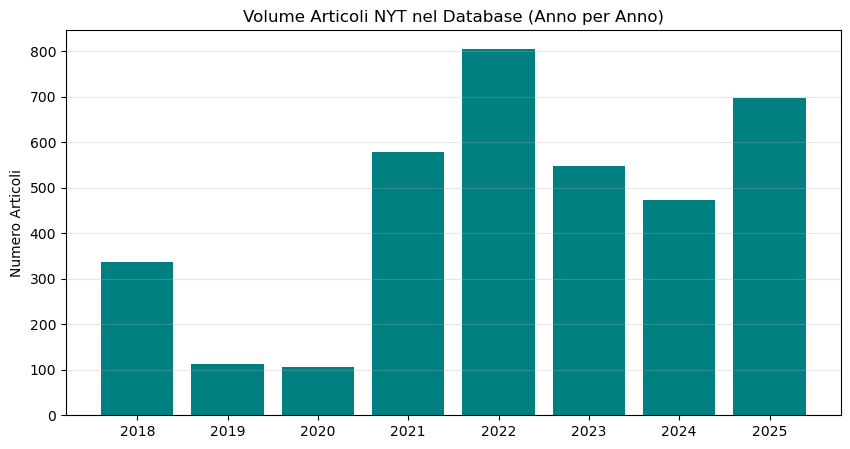

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from pymongo import MongoClient

# Connessione
client = MongoClient("mongodb://localhost:27017")
db = client['btc_def2']
collection = db['Article']

# Aggregazione: Conta articoli per Anno
pipeline = [
    {
        "$project": {
            "year": {"$substr": ["$date_str", 0, 4]}, # Prendi i primi 4 caratteri della data (YYYY)
            "article_count": {"$size": "$articles"}   # Conta quanti articoli ci sono nell'array
        }
    },
    {
        "$group": {
            "_id": "$year",
            "total_articles": {"$sum": "$article_count"}, # Somma totale articoli
            "days_with_news": {"$sum": 1} # Conta giorni che hanno almeno una entry
        }
    },
    {"$sort": {"_id": 1}} # Ordina dal 2018 al 2024
]

results = list(collection.aggregate(pipeline))

# Stampa Tabella
print(f"{'ANNO':<10} | {'ARTICOLI TOTALI':<15} | {'GIORNI NEL DB':<15}")
print("-" * 45)
for r in results:
    print(f"{r['_id']:<10} | {r['total_articles']:<15} | {r['days_with_news']:<15}")

# Grafico veloce
years = [r['_id'] for r in results]
counts = [r['total_articles'] for r in results]

plt.figure(figsize=(10, 5))
plt.bar(years, counts, color='teal')
plt.title("Volume Articoli NYT nel Database (Anno per Anno)")
plt.ylabel("Numero Articoli")
plt.grid(axis='y', alpha=0.3)
plt.show()

🔌 Connesso a MongoDB: btc_def2.Article
🤖 Caricamento FinBERT...


Device set to use cpu


📥 Scarico tutti i documenti dal DB...
✅ Trovati 2902 giorni nel DB. Inizio analisi approfondita...


Analisi Globale: 100%|██████████| 2902/2902 [03:43<00:00, 12.96it/s]



📊 Analizzati 3658 articoli totali.
Counts: {'positive': 270, 'neutral': 2232, 'negative': 1156}


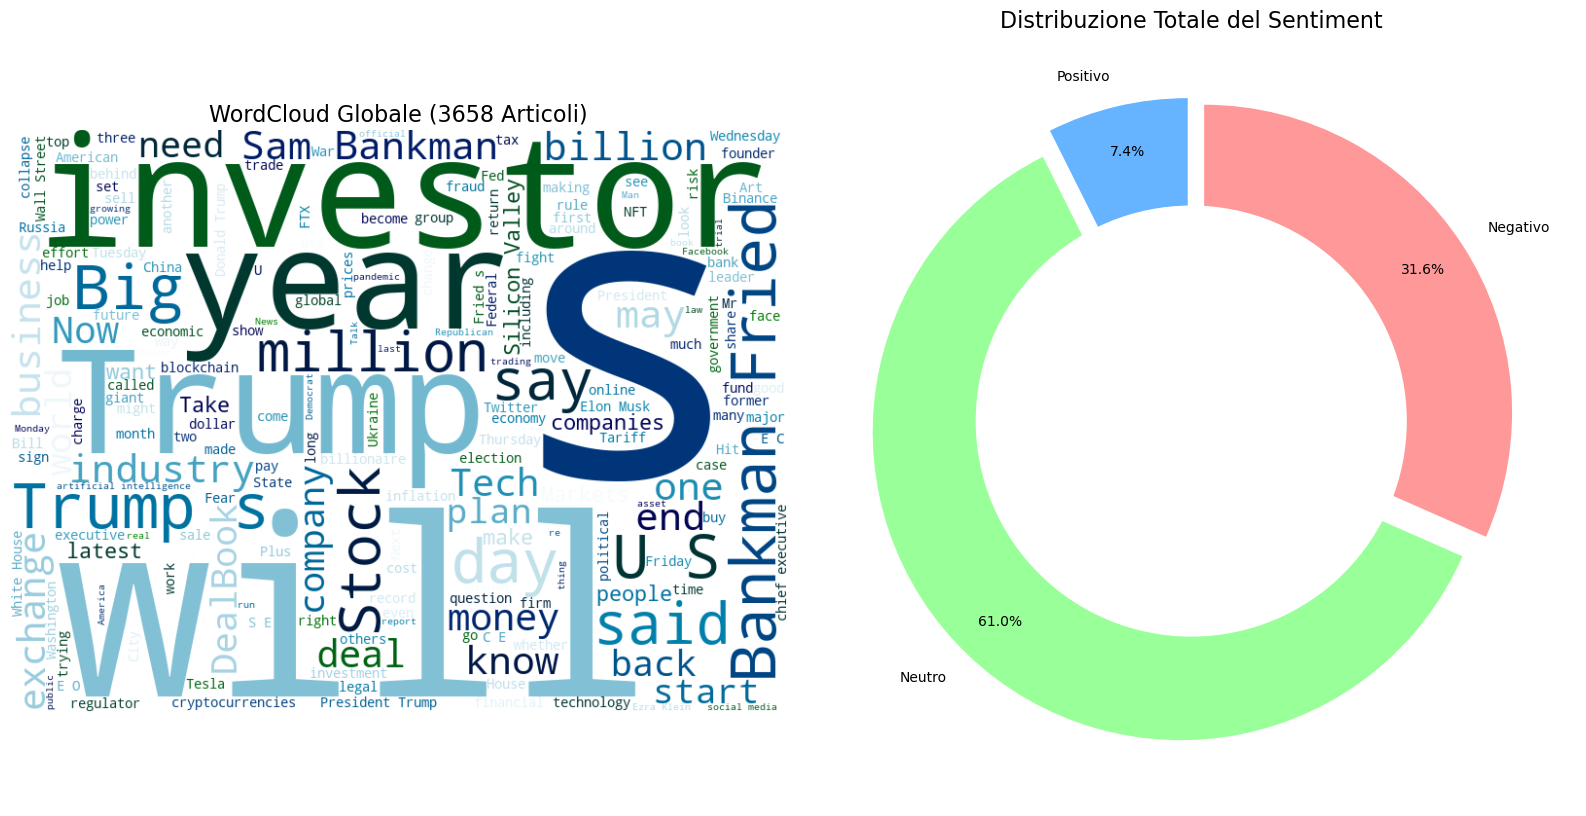

In [28]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
# --- 1. CONNESSIONE AL DB ---
client = MongoClient("mongodb://localhost:27017")
db_name = 'btc_def2' 
collection_name = 'Article'
db = client[db_name]
collection = db[collection_name]

print(f"🔌 Connesso a MongoDB: {db_name}.{collection_name}")

# --- 2. CARICAMENTO FINBERT ---
print("🤖 Caricamento FinBERT...")
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
device = 0 if torch.cuda.is_available() else -1 # Usa GPU se c'è
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

# --- 3. ESTRAZIONE DI TUTTI GLI ARTICOLI ---
print("📥 Scarico tutti i documenti dal DB...")
cursor = collection.find({}) # Prende tutto senza filtri data
all_docs = list(cursor)

print(f"✅ Trovati {len(all_docs)} giorni nel DB. Inizio analisi approfondita...")

# Variabili accumulo
sentiment_counts = {'positive': 0, 'neutral': 0, 'negative': 0}
all_text_accumulated = ""
total_articles = 0

# --- 4. CICLO DI ANALISI ---
for doc in tqdm(all_docs, desc="Analisi Globale"):
    articles = doc.get('articles', [])
    
    for art in articles:
        # Uniamo titolo e abstract
        t = art.get('title', '')
        a = art.get('abstract', '')
        if t is None: t = ""
        if a is None: a = ""
        
        full_text = f"{t}. {a}".strip()
        
        # Se il testo è valido (più lungo di 10 caratteri)
        if len(full_text) > 10:
            total_articles += 1
            
            # 1. Aggiungi al testo per WordCloud
            all_text_accumulated += " " + full_text
            
            # 2. Calcola Sentiment
            try:
                # FinBERT accetta max 512 token
                res = nlp(full_text[:512])[0]
                label = res['label']
                sentiment_counts[label] += 1
            except Exception:
                pass # Ignora errori su testi corrotti

print(f"\n📊 Analizzati {total_articles} articoli totali.")
print(f"Counts: {sentiment_counts}")

# --- 5. VISUALIZZAZIONE ---
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2)

# GRAFICO A: WordCloud Globale
ax1 = fig.add_subplot(gs[0])

# Stopwords (parole da ignorare)
my_stopwords = set(STOPWORDS)
my_stopwords.update(["Bitcoin", "Crypto", "Cryptocurrency", "Currency", "Digital", "Market", "Price", "New", "York", "Times", "Briefing", "Week", "Today"])

wc = WordCloud(width=800, height=600, 
               background_color='white', 
               stopwords=my_stopwords, 
               colormap='ocean', # Colormap generale (blu/verde)
               max_words=200).generate(all_text_accumulated)

ax1.imshow(wc, interpolation='bilinear')
ax1.axis('off')
ax1.set_title(f"WordCloud Globale ({total_articles} Articoli)", fontsize=16)

# GRAFICO B: Torta del Sentiment (Pie Chart)
ax2 = fig.add_subplot(gs[1])

labels = ['Positivo', 'Neutro', 'Negativo']
sizes = [sentiment_counts['positive'], sentiment_counts['neutral'], sentiment_counts['negative']]
colors = ['#66b3ff', '#99ff99', '#ff9999'] # Blu, Verde, Rosso chiaro
explode = (0.05, 0.05, 0.05) # Stacca leggermente le fette

ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, explode=explode)

# Disegna cerchio bianco al centro per fare effetto "Ciambella"
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax2.set_title('Distribuzione Totale del Sentiment', fontsize=16)

plt.tight_layout()
plt.show()

🔄 Re-processing text to separate Positive vs Negative content...


Splitting Sentiment: 100%|██████████| 2902/2902 [08:46<00:00,  5.51it/s]



✅ Separation complete!
Positive articles: 270
Negative articles: 1156


C:\Users\HP\AppData\Local\Temp\ipykernel_21944\1238935997.py:99: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\1238935997.py:99: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


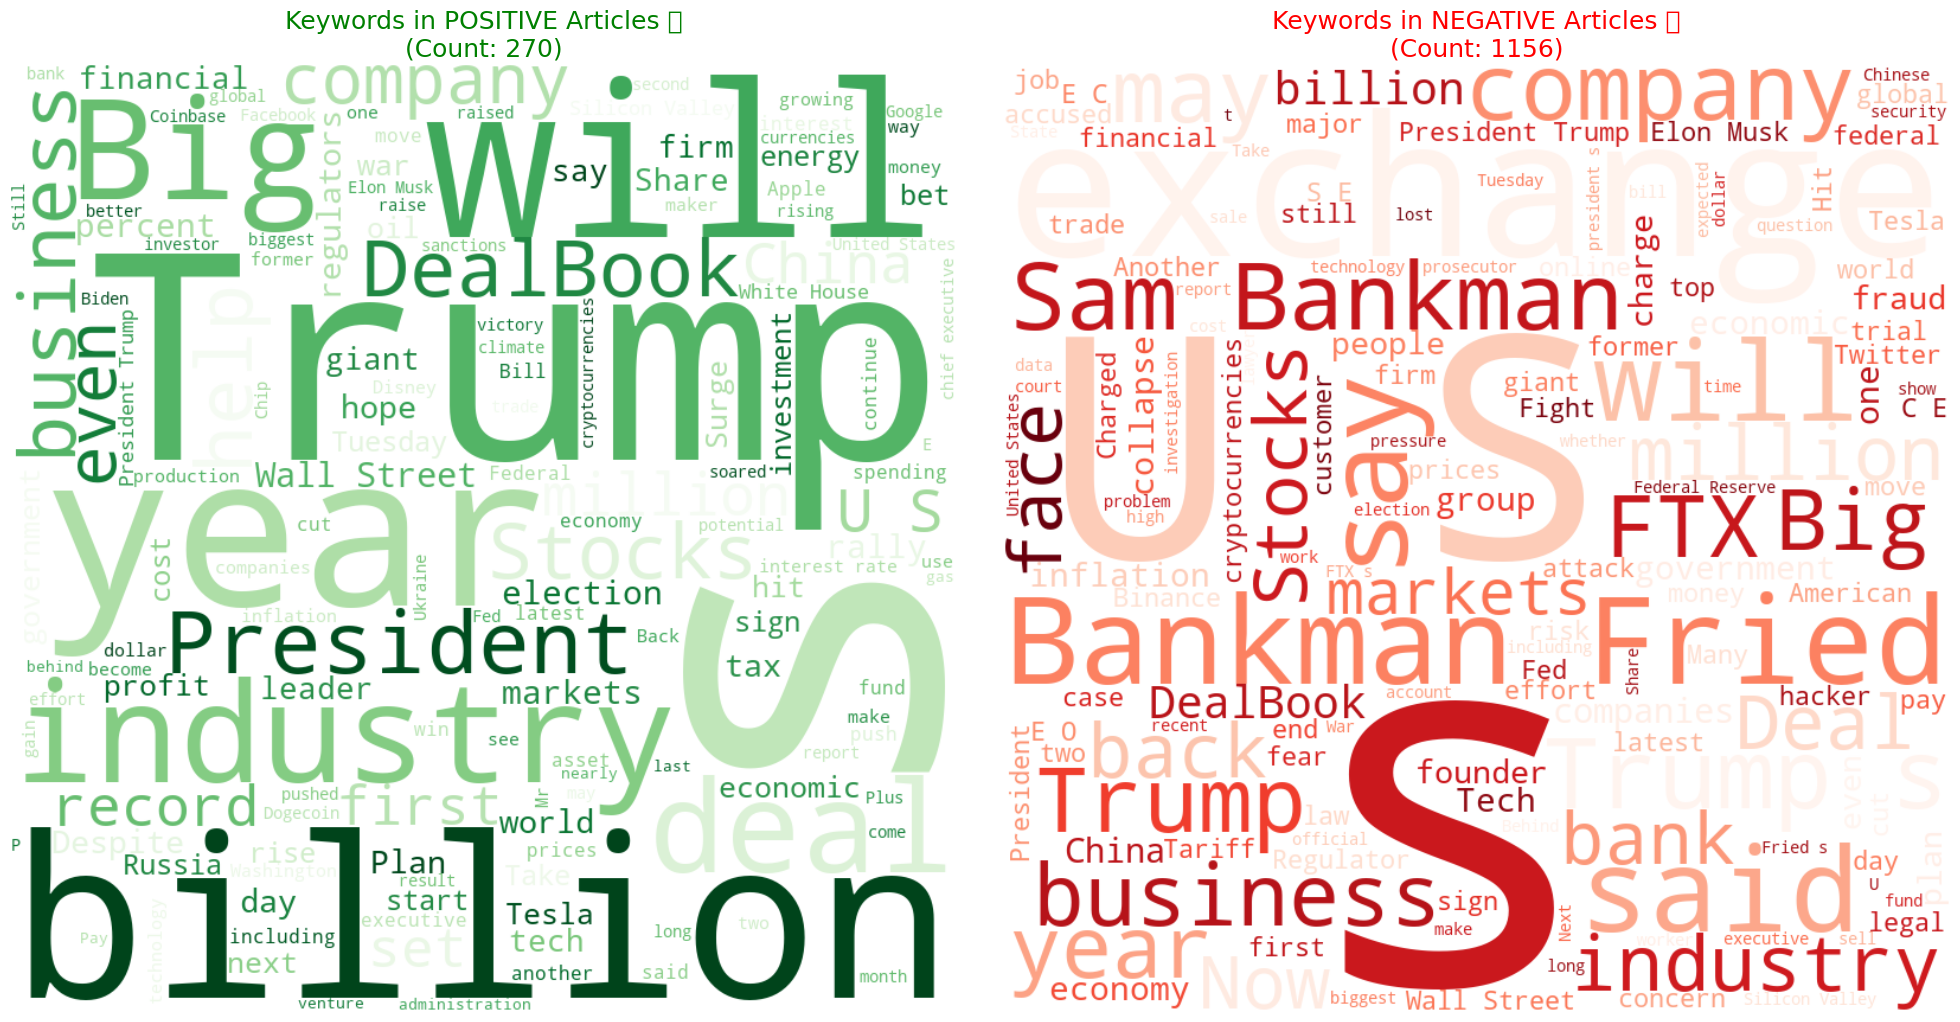

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

# --- OPTIMIZATION NOTE ---
# We reuse 'all_docs' and 'nlp' from the previous cell to save RAM and time.
# We do not need to reload the model or fetch data from MongoDB again.

print("🔄 Re-processing text to separate Positive vs Negative content...")

# Initialize empty strings for the split WordClouds
text_positive = ""
text_negative = ""
count_pos_articles = 0
count_neg_articles = 0

# We iterate over the existing 'all_docs' list (already in memory)
for doc in tqdm(all_docs, desc="Splitting Sentiment"):
    articles = doc.get('articles', [])
    
    for art in articles:
        # Extract and clean text
        t = art.get('title', '')
        a = art.get('abstract', '')
        if t is None: t = ""
        if a is None: a = ""
        
        full_text = f"{t}. {a}".strip()
        
        # Check text length
        if len(full_text) > 10:
            try:
                # RE-INFERENCE: We need to classify again to know which bucket to put the text in
                # (Since the previous code didn't save the label-text association)
                res = nlp(full_text[:512])[0]
                label = res['label']
                
                # Separate text into two different buckets
                if label == 'positive':
                    text_positive += " " + full_text
                    count_pos_articles += 1
                elif label == 'negative':
                    text_negative += " " + full_text
                    count_neg_articles += 1
                
            except Exception:
                pass

print(f"\n✅ Separation complete!")
print(f"Positive articles: {count_pos_articles}")
print(f"Negative articles: {count_neg_articles}")

# --- VISUALIZATION ---

if count_pos_articles == 0 and count_neg_articles == 0:
    print("⚠️ No articles found for visualization.")
else:
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Define Stopwords
    my_stopwords = set(STOPWORDS)
    my_stopwords.update([
        "Bitcoin", "Crypto", "Cryptocurrency", "Currency", "Digital", 
        "Market", "Price", "New", "York", "Times", "Briefing", 
        "Week", "Today", "Investors", "Trading", "Stock"
    ])

    # A. POSITIVE WordCloud (Green)
    if len(text_positive) > 0:
        wc_pos = WordCloud(
            width=800, height=800, 
            background_color='white', 
            stopwords=my_stopwords, 
            colormap='Greens',  
            max_words=150
        ).generate(text_positive)
        
        ax1.imshow(wc_pos, interpolation='bilinear')
        ax1.set_title(f"Keywords in POSITIVE Articles 🚀\n(Count: {count_pos_articles})", fontsize=18, color='green')
    
    ax1.axis('off')

    # B. NEGATIVE WordCloud (Red)
    if len(text_negative) > 0:
        wc_neg = WordCloud(
            width=800, height=800, 
            background_color='white', 
            stopwords=my_stopwords, 
            colormap='Reds',    
            max_words=150
        ).generate(text_negative)
        
        ax2.imshow(wc_neg, interpolation='bilinear')
        ax2.set_title(f"Keywords in NEGATIVE Articles 📉\n(Count: {count_neg_articles})", fontsize=18, color='red')
    
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

🔧 Configuring Text Cleaner...
🧹 Cleaning Positive Text...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


🧹 Cleaning Negative Text...
✅ Text cleaning complete!


C:\Users\HP\AppData\Local\Temp\ipykernel_21944\3970102656.py:120: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_21944\3970102656.py:120: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


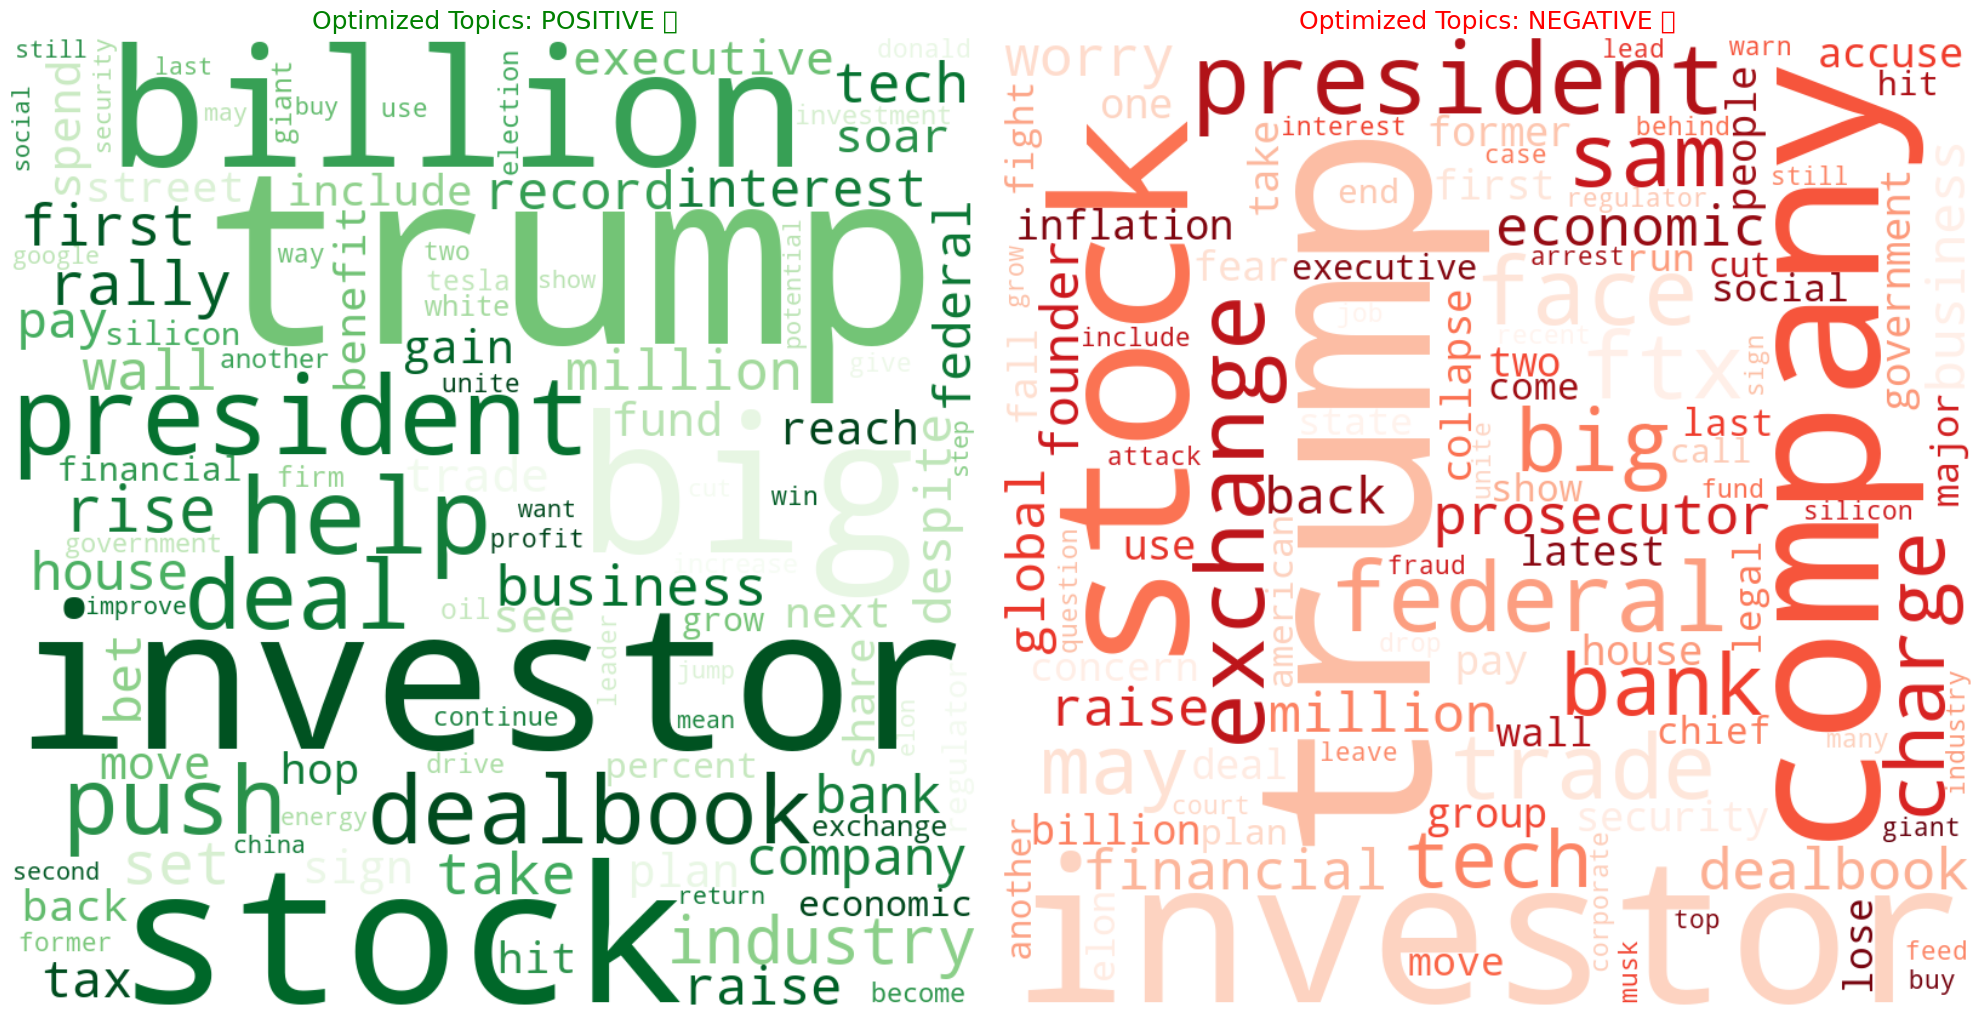

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# --- 1. SETUP NLTK (Natural Language Toolkit) ---
print("🔧 Configuring Text Cleaner...")
# Download necessary dictionaries (only needs to be done once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# --- 2. DEFINE CUSTOM STOPWORDS (The "Blacklist") ---
# Start with standard English stopwords
custom_stopwords = set(STOPWORDS)

# Add standard NLTK stopwords
from nltk.corpus import stopwords
custom_stopwords.update(stopwords.words('english'))

# Add "Journalistic Noise" (words used in NYT writing style)
journalism_noise = [
    "said", "say", "says", "reported", "according", "mr", "ms", "mrs", 
    "editor", "opinion", "page", "section", "news", "report", "writer",
    "briefing", "evening", "morning", "daily", "week", "year", "month",
    "today", "yesterday", "time", "day", "new", "york", "times"
]

# Add "Obvious Domain Words" (words that are too generic for this topic)
# You might want to keep 'crypto' but remove 'currency' or 'digital'
domain_noise = [
    "bitcoin", "crypto", "cryptocurrency", "currency", "digital", 
    "market", "price", "money", "value", "coin", "token",
    "going", "make", "made", "would", "could", "also", "even"
]

custom_stopwords.update(journalism_noise)
custom_stopwords.update(domain_noise)

# --- 3. CLEANING FUNCTION ---
def clean_and_lemmatize(text):
    if not text: return ""
    
    # PROVIAMO CON NLTK (Metodo Avanzato)
    try:
        tokens = word_tokenize(text.lower())
    # SE FALLISCE, USIAMO IL METODO BASE (Piano B)
    except LookupError:
        tokens = text.lower().split() 
    
    cleaned_tokens = []
    for word in tokens:
        # Filtro: Solo lettere, lunghe > 2 char, no stopwords
        if word.isalpha() and len(word) > 2 and word not in custom_stopwords:
            try:
                # Lemmatizzazione
                lemma = lemmatizer.lemmatize(word, pos='v') 
                lemma = lemmatizer.lemmatize(lemma, pos='n') 
                
                if lemma not in custom_stopwords:
                    cleaned_tokens.append(lemma)
            except Exception:
                # Se anche il lemmatizer fallisce, teniamo la parola originale
                cleaned_tokens.append(word)
                
    return " ".join(cleaned_tokens)
# --- 4. APPLY CLEANING ---
print("🧹 Cleaning Positive Text...")
clean_pos_text = clean_and_lemmatize(text_positive)

print("🧹 Cleaning Negative Text...")
clean_neg_text = clean_and_lemmatize(text_negative)

print("✅ Text cleaning complete!")

# --- 5. GENERATE IMPROVED VISUALIZATION ---

if not clean_pos_text and not clean_neg_text:
    print("⚠️ No valid text remaining after filtering.")
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # A. POSITIVE WordCloud
    if len(clean_pos_text) > 0:
        wc_pos = WordCloud(
            width=800, height=800, 
            background_color='white', 
            stopwords=custom_stopwords, # Apply stopwords again just in case
            colormap='Greens',  
            min_font_size=10,
            max_words=100,
            collocations=False # Avoid repeating phrases like "New York"
        ).generate(clean_pos_text)
        
        ax1.imshow(wc_pos, interpolation='bilinear')
        ax1.set_title(f"Optimized Topics: POSITIVE 🚀", fontsize=18, color='green')
    ax1.axis('off')

    # B. NEGATIVE WordCloud
    if len(clean_neg_text) > 0:
        wc_neg = WordCloud(
            width=800, height=800, 
            background_color='white', 
            stopwords=custom_stopwords,
            colormap='Reds',    
            min_font_size=10,
            max_words=100,
            collocations=False
        ).generate(clean_neg_text)
        
        ax2.imshow(wc_neg, interpolation='bilinear')
        ax2.set_title(f"Optimized Topics: NEGATIVE 📉", fontsize=18, color='red')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

🔌 Connected to DB. Running analysis...

📢 TOPIC: PRESIDENT TRUMP
📊 Articles found: 611
------------------------------------------------------------
🎲 5 Representative Examples (Title + Abstract):
   1. Trump’s Crypto Venture Divides the Industry He Aims to Support. The president’s promotion of a speculative digital coin left some crypto investors fee...
   2. Republicans Rely on Trump’s Promises to Grease the Path for His Agenda. G.O.P. leaders scrounging for the votes to push through the president’s priori...
   3. Trump Order Clears Way for Crypto and Private Equity in 401(k)s. The executive order is intended to give investors more options, but experts say emplo...
   4. Michael Hayden: The End of Intelligence. How do you brief a president who doesn’t distinguish between truth and lies?...
   5. Trump Removed His Top National Security Aide. Also, scientists are investigating metformin’s anti-aging abilities. Here’s the latest at the end of Thu...




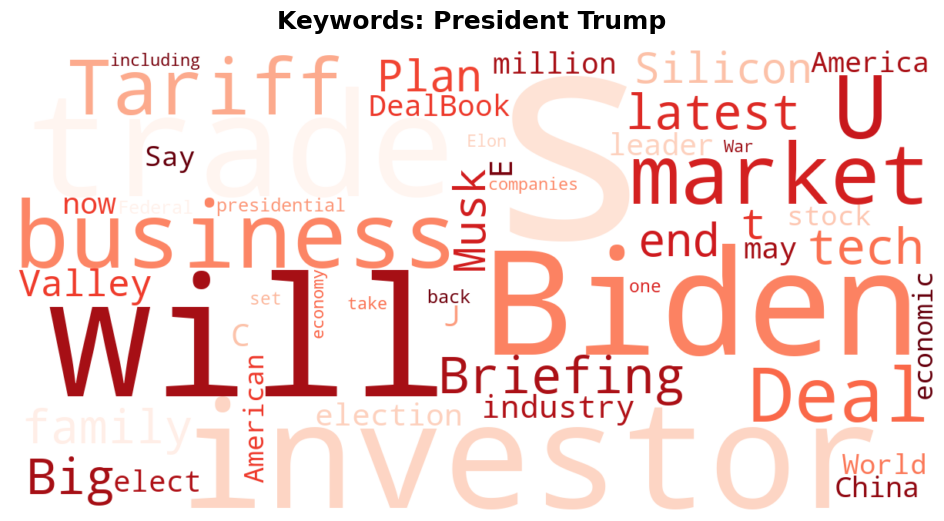




📢 TOPIC: ELON MUSK
📊 Articles found: 458
------------------------------------------------------------
🎲 5 Representative Examples (Title + Abstract):
   1. Twitter’s Nest Gets a Little Emptier. Hundreds of workers decided to leave the troubled social network, after Elon Musk demanded employees commit to a...
   2. Mr. Musk Goes to Washington — With a $2 Trillion Agenda. Donald Trump tapped the tech mogul to co-lead an effort to slash government spending, but que...
   3. Shaming Apple and Texting Musk, a Ukraine Minister Uses Novel War Tactics. Mykhailo Fedorov, Ukraine’s youngest minister, has turned technology, crypt...
   4. Three New Stand-Up Specials, Three Very Different Approaches. In the mix this month are hour sets from a maturing Marc Maron, a very funny Nathan Maci...
   5. How FTX Missed a Potentially Lucrative Opportunity. A decision to offload warrants to buy an obscure cryptocurrency token as part of the exchange’s ba...




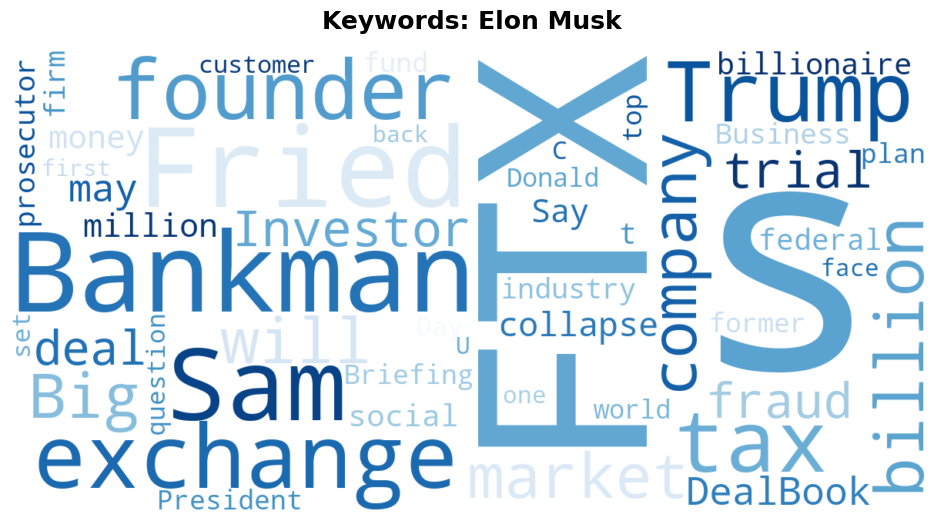




📢 TOPIC: FRAUD & SCANDALS
📊 Articles found: 389
------------------------------------------------------------
🎲 5 Representative Examples (Title + Abstract):
   1. Crypto Lobbyist Charged With Breaking Campaign Finance Rules. The charges against Michelle Bond, a former head of a crypto industry trade group, are p...
   2. ‘Oof’: Sam Bankman-Fried’s Trial Reveals Inside Details of How FTX Died. Prosecutors in the criminal fraud case have built the most intricate account ...
   3. The Cryptocurrency Scam That Turned a Small Town Against Itself. How did a successful, financially sophisticated banker gamble his community’s money a...
   4. Americans Have Lost Billions to Online Scams. How Is That Possible?. The United States, Britain and South Korea have joined a crackdown on groups runn...
   5. Sam Bankman-Fried Blames ‘Huge Management Failures’ for FTX Collapse. Mr. Bankman-Fried spoke at The New York Times’s DealBook conference, in his firs...




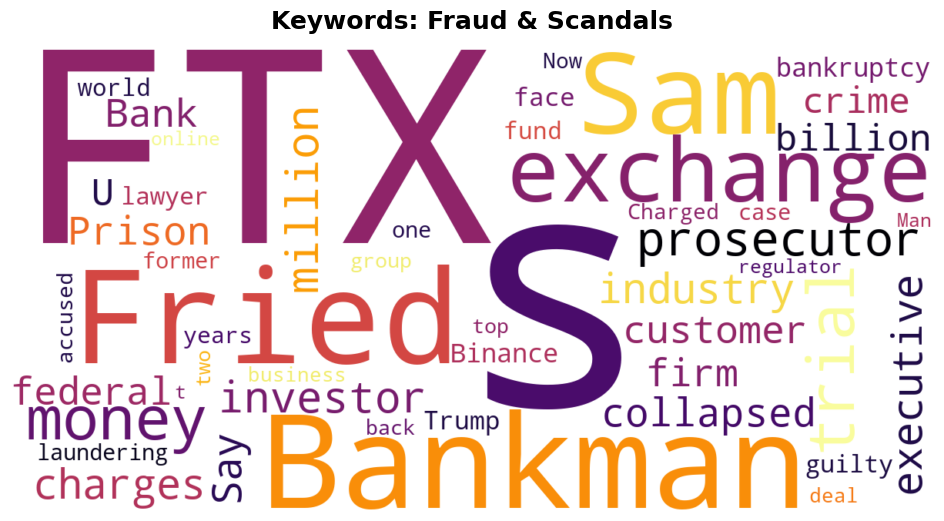




📢 TOPIC: REGULATION & SEC
📊 Articles found: 853
------------------------------------------------------------
🎲 5 Representative Examples (Title + Abstract):
   1. Everything We Learned From the Sam Bankman-Fried Interview. The 30-year-old crypto entrepreneur made his first public appearance since the collapse of...
   2. Jack Dorsey creates a fund to address Bitcoin developers’ ‘legal headaches.’. The fund will provide free legal advice and rely primarily on part-time ...
   3. No, You Don’t Actually Have a Right to a Bank Account. There is a degree of political agreement over so-called debanking, but no easy answers to the h...
   4. Losses Pile Up in FTX Bankruptcy Turmoil. The crypto exchange’s founder, Sam Bankman-Fried, says the company suffered a $51 billon collapse in collate...
   5. A Party Crawl With Pussy Riot’s Nadya Tolokonnikova. At 21, she was a founding member of the Russian anti-government punk collective. At 22, she was i...




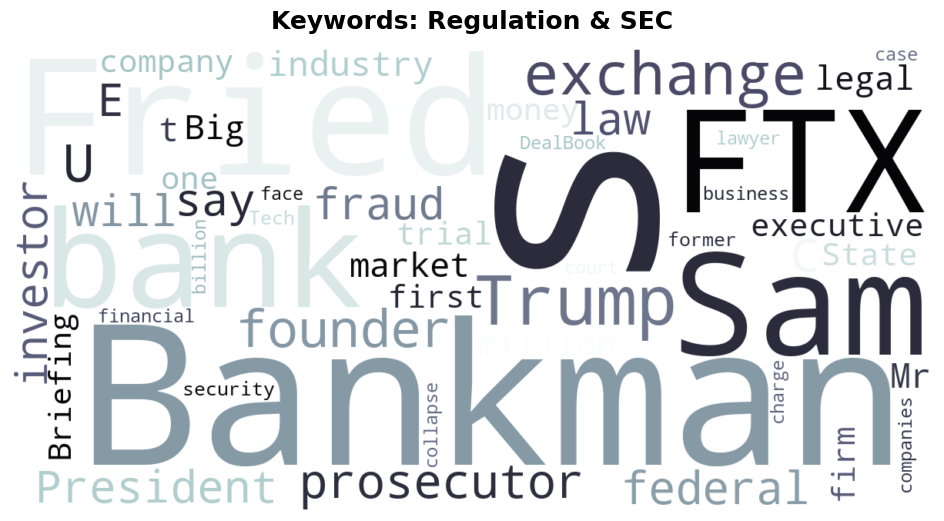




📢 TOPIC: MARKET TRENDS
📊 Articles found: 691
------------------------------------------------------------
🎲 5 Representative Examples (Title + Abstract):
   1. Stocks bounce back after a rough week.. Markets regained some ground after a tumultuous week on Wall Street....
   2. The White House Renews Its Attack on ‘Surprise Fees’. President Biden will host executives from several companies, including Airbnb and Live Nation, t...
   3. The Real-World Costs of the Digital Race for Bitcoin. Bitcoin mines cash in on electricity — by devouring it, selling it, even turning it off — and th...
   4. Trump Pardons Creator of Silk Road Drug Marketplace. Ross Ulbricht was serving a life sentence for creating a site in a shady corner of the internet t...
   5. John Cleese joins the digital art market frenzy — with a wink.. The highest bid for Mr. Cleese’s work is now about $36,000. “I think it’s very funny,”...




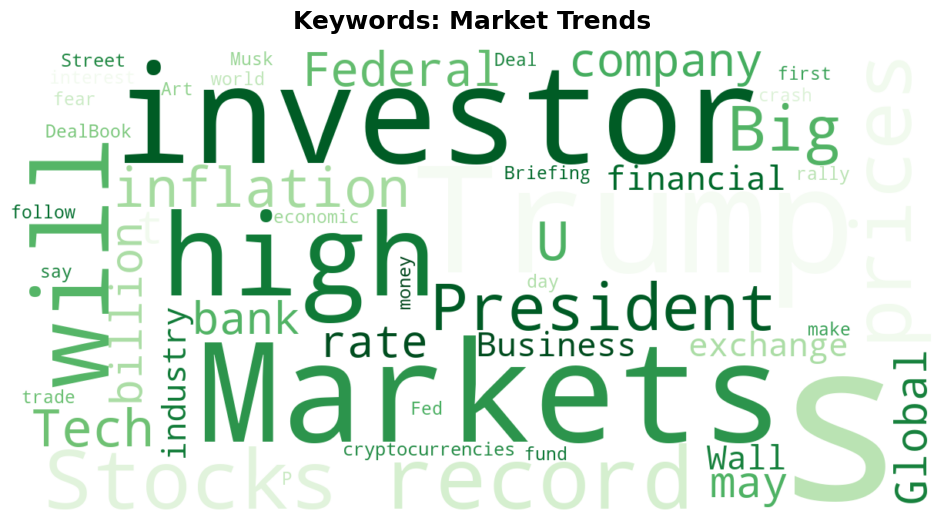

In [ ]:
import random

# --- 1. CONFIGURATION: TOPICS & COLORS ---
TOPICS_CONFIG = {
    "President Trump": {
        "keywords": ["trump", "donald", "president", "white house"],
        "stopwords_extra": ["trump", "donald", "president", "former", "white", "house", "mr", "administration", "campaign"],
        "colormap": "Reds"  # Political Red
    },
    "Elon Musk": {
        "keywords": ["musk", "elon", "tesla", "spacex", "twitter", "x "], 
        "stopwords_extra": ["musk", "elon", "tesla", "twitter", "mr", "chief", "executive", "owner", "tech"],
        "colormap": "Blues" # Tech/Twitter Blue
    },
    "Fraud & Scandals": {
        "keywords": ["fraud", "scam", "ponzi", "scheme", "crime", "criminal", "prison", "jail", "bankrupt", "ftx", "sbf", "collapse", "laundering"],
        "stopwords_extra": ["fraud", "scam", "scheme", "criminal", "bankrupt", "collapse", "mr", "company", "founder"],
        "colormap": "inferno" # Danger/Fire
    },
    "Regulation & SEC": {
        "keywords": ["sec", "regulation", "law", "gensler", "government", "ban", "congress", "senate", "legal"],
        "stopwords_extra": ["sec", "regulation", "regulators", "rule", "government", "commission", "agency"],
        "colormap": "bone" # Serious/Grey
    },
    "Market Trends": {
        "keywords": ["price", "market", "crash", "rally", "plunge", "record", "high", "low", "volatility"],
        "stopwords_extra": ["price", "market", "value", "digital", "currency", "level", "trading", "stock"],
        "colormap": "Greens" # Money/Growth
    }
}

# --- 2. DATA RETRIEVAL ---
client = MongoClient("mongodb://localhost:27017")
db = client['btc_def2']
collection = db['Article']

print("🔌 Connected to DB. Running analysis...\n")

# Initialize containers for text
topic_texts = {k: [] for k in TOPICS_CONFIG.keys()}
cursor = collection.find({})

# Scan documents
for doc in cursor:
    articles = doc.get('articles', [])
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        full_text = f"{t}. {a}".strip()
        
        # Filter valid text
        if len(full_text) > 15:
            full_text_lower = full_text.lower()
            
            # Check keywords for each topic
            for topic, config in TOPICS_CONFIG.items():
                if any(k in full_text_lower for k in config["keywords"]):
                    topic_texts[topic].append(full_text)

# --- 3. REPORT GENERATION (TEXT + PLOTS) ---
base_stopwords = set(STOPWORDS)
# Add common generic words to ignore
base_stopwords.update(["Bitcoin", "Crypto", "Cryptocurrency", "Digital", "Currency", "New", "York", "Times", "Said", "Week", "Today", "Year", "People"])

for topic_name, texts_list in topic_texts.items():
    count = len(texts_list)
    config = TOPICS_CONFIG[topic_name]
    
    print("=" * 60)
    print(f"📢 TOPIC: {topic_name.upper()}")
    print(f"📊 Articles found: {count}")
    print("-" * 60)
    
    # A. PRINT TEXT EXAMPLES (Title + Abstract)
    if count > 0:
        print(f"🎲 5 Representative Examples (Title + Abstract):")
        sample_size = min(5, count)
        
        # Clean newlines for better display
        samples = [t.replace('\n', ' ') for t in random.sample(texts_list, sample_size)]
        
        for idx, txt in enumerate(samples, 1):
            # Truncate to 150 chars
            print(f"   {idx}. {txt[:150]}...")
    else:
        print("   (No articles found)")

    print("\n") # Spacer

    # B. GENERATE WORDCLOUD (Separate Figure)
    if count > 0:
        combined_text = " ".join(texts_list)
        
        # Update stopwords specific to this topic
        current_stopwords = base_stopwords.copy()
        extras = [w.lower() for w in config["stopwords_extra"]]
        current_stopwords.update(extras)
        
        # Create a NEW figure for each topic
        plt.figure(figsize=(12, 6)) # Panoramic 2:1 aspect ratio
        
        wc = WordCloud(width=1200, height=600, 
                       background_color='white', 
                       stopwords=current_stopwords, 
                       collocations=False, # Prevents double words (e.g. removes "Trump Campaign" if "Trump" is banned)
                       colormap=config['colormap'], # Specific theme color
                       max_words=50).generate(combined_text)
        
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f"Keywords: {topic_name}", fontsize=18, fontweight='bold', pad=15)
        plt.axis('off')
        plt.show() # Render plot immediately
    else:
        print(f"⚠️ No data available to generate WordCloud for {topic_name}.\n")

    print("\n" * 2) # Double spacer between blocks

📥 Fetching data...
✅ Loaded 3652 documents.


C:\Users\HP\AppData\Local\Temp\ipykernel_21944\4103642735.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=df_bigrams, palette='viridis')


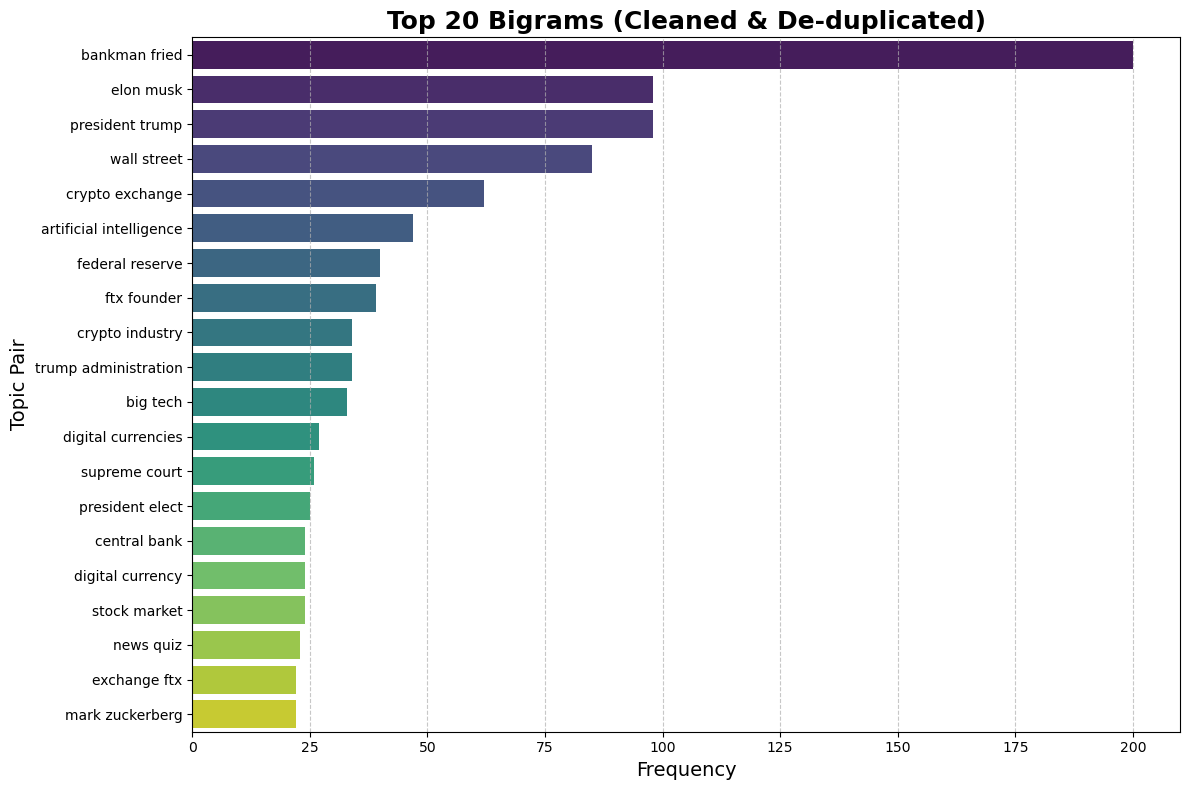


🔍 TOP 10 CLEAN BIGRAMS:
   1. Bankman Fried (200)
   2. Elon Musk (98)
   3. President Trump (98)
   4. Wall Street (85)
   5. Crypto Exchange (62)
   6. Artificial Intelligence (47)
   7. Federal Reserve (40)
   8. Ftx Founder (39)
   9. Crypto Industry (34)
   10. Trump Administration (34)


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# --- 1. DATA CONNECTION ---
client = MongoClient("mongodb://localhost:27017")
db = client['btc_def2']
collection = db['Article']

print("📥 Fetching data...")
corpus = []
cursor = collection.find({})

for doc in cursor:
    articles = doc.get('articles', [])
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        full_text = f"{t} {a}".strip()
        if len(full_text) > 20:
            corpus.append(full_text)

print(f"✅ Loaded {len(corpus)} documents.")

# --- 2. ADVANCED CLEANING CONFIGURATION ---

# A. EXPANDED STOPWORDS (Removes "Useless" noise)
# We add words that form useless phrases like "Need to know", "Start of day", etc.
custom_stopwords = list(ENGLISH_STOP_WORDS) + [
    # Journalism/NYT specific noise
    "new", "york", "times", "briefing", "daily", "today", "week", "year",
    "mr", "ms", "mrs", "said", "say", "says", "reporting", "source",
    "image", "photo", "credit", "getty", "associated", "press", 
    # Specific noise found in your chart ("need know", "start day", "latest end")
    "need", "know", "start", "day", "latest", "end", "posted", "updated",
    "ezra", "klein", "podcast", "transcript", "listen",
    "chief", "executive", "officer", "general", # Generic titles
    "united", "states", "white", "house" # Too generic for this context? (Optional)
]

# B. REDUNDANCY FILTER (Removes "Similar/Redundant" pairs)
# List of specific bigrams you want to hide because a better synonym exists
banned_bigrams = [
    "sam bankman",        # Redundant: "bankman fried" is enough
    "donald trump",       # Redundant: "president trump" is enough
    "cryptocurrency exchange", # Redundant: "crypto exchange" is shorter/better
    "silicon valley",     # Often too generic
    "social media",       # Too generic
    "start day",          # Noise
    "latest end",         # Noise
    "need know",          # Noise
    "dealbook newsletter" # Noise
]

# --- 3. EXTRACTING BIGRAMS ---
vectorizer = CountVectorizer(
    ngram_range=(2, 2),
    stop_words=custom_stopwords,
    min_df=5,
    max_features=2000 # Extract more initially, then filter
)

X = vectorizer.fit_transform(corpus)

# Convert to list of (Bigram, Count)
bigrams_list = list(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

# --- 4. APPLYING FILTERS ---
cleaned_bigrams = []
for bigram, count in bigrams_list:
    # Check if the bigram is in our "banned" list
    if bigram not in banned_bigrams:
        cleaned_bigrams.append((bigram, count))

# Sort by frequency
sorted_bigrams = sorted(cleaned_bigrams, key=lambda x: x[1], reverse=True)

# Select Top 20 CLEAN bigrams
top_20 = sorted_bigrams[:20]
df_bigrams = pd.DataFrame(top_20, columns=['Bigram', 'Frequency'])

# --- 5. VISUALIZATION ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Bigram', data=df_bigrams, palette='viridis')

plt.title('Top 20 Bigrams (Cleaned & De-duplicated)', fontsize=18, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Topic Pair', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 6. PRINT RESULTS ---
print("\n🔍 TOP 10 CLEAN BIGRAMS:")
for i, (gram, freq) in enumerate(top_20[:10], 1):
    print(f"   {i}. {gram.title()} ({freq})")